In [1]:
# Import libraries
import gzip
import shutil
import os
import json 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Train Test Split, SMOTE
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc,
    make_scorer, average_precision_score)
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from joblib import dump, load

# 1. Reading and Parsing Features (JSON format) and labels

## 1.1 Parse features JSON

In [2]:
# Specify the input and output file names (adjust file paths if needed)
input_file = '../data/dataset0.json.gz'  

# Unzip the file
def unzip_file(input):
    '''
    Unzips gzfile. If input is not a gzfile, it will return input filepath.

    Parameter:
    - Input: Filepath

    Output:
    - Output: Filepath on unzipped file
    '''
    if input.endswith('.gz'):
        output = input[:-3]
    else:
        print("Input file is not a .gz file. Unzipping not required")
        return input
    
    with gzip.open(input, 'rb') as f_in:
        with open(output, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    print(f'File unzipped successfully. Output file: {output}')

    return output

In [3]:
unzip_file(input_file)

File unzipped successfully. Output file: ../data/dataset0.json


'../data/dataset0.json'

In [4]:
input_file = '../data/dataset0.json' 

def flatten_json(input_file):
    '''
    Flattens input json file with each line corresponding to information for one transcript.
    Returns dataframe with each line corresponding to one read of each transcript.

    Input:
    - input_file: json file path

    Output:
    - df: pd.Dataframe with each line corresponding to one read of each transcript
    '''
    
    import json 
    import pandas as pd
    
    data = []
    with open(input_file, 'r') as file:
        for line in file:
            # Parse each line as a JSON object
            data.append(json.loads(line))
    
    rows = []

    for entry in data:
        for transcript_id, positions in entry.items():
            for position, sequences in positions.items():
                for sequence, features in sequences.items():
                    for feature_set in features:
                        row = {
                            'transcript_id': transcript_id,
                            'transcript_position': position,
                            'sequence': sequence,
                            '-1_dwelling_time': feature_set[0],
                            '-1_standard_dev': feature_set[1],
                            '-1_mean_current': feature_set[2],
                            '0_dwelling_time': feature_set[3],
                            '0_standard_dev': feature_set[4],
                            '0_mean_current': feature_set[5],
                            '+1_dwelling_time': feature_set[6],
                            '+1_standard_dev': feature_set[7],
                            '+1_mean_current': feature_set[8],
                        }
                        rows.append(row)

    df = pd.DataFrame(rows)
    return df

In [5]:
# Flatten the data
flattened_data = flatten_json(input_file)
print(flattened_data.head())
print(flattened_data.info())

     transcript_id transcript_position sequence  -1_dwelling_time  \
0  ENST00000000233                 244  AAGACCA           0.00299   
1  ENST00000000233                 244  AAGACCA           0.00631   
2  ENST00000000233                 244  AAGACCA           0.00465   
3  ENST00000000233                 244  AAGACCA           0.00398   
4  ENST00000000233                 244  AAGACCA           0.00664   

   -1_standard_dev  -1_mean_current  0_dwelling_time  0_standard_dev  \
0             2.06            125.0          0.01770           10.40   
1             2.53            125.0          0.00844            4.67   
2             3.92            109.0          0.01360           12.00   
3             2.06            125.0          0.00830            5.01   
4             2.92            120.0          0.00266            3.94   

   0_mean_current  +1_dwelling_time  +1_standard_dev  +1_mean_current  
0           122.0           0.00930            10.90             84.1  
1       

In [6]:
# Export as csv
path = '../data/dataset0.csv'
flattened_data.to_csv(path, index=False)


## 1.2 Read in labels and features

In [7]:
def read_labels(labels_file):

    labels = pd.read_csv(labels_file)
    return labels

labels = read_labels('../data/data.info.labelled')

print(labels.info())  # To get summary information about the DataFrame
print(labels.head())  # Preview the first few rows of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121838 entries, 0 to 121837
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   gene_id              121838 non-null  object
 1   transcript_id        121838 non-null  object
 2   transcript_position  121838 non-null  int64 
 3   label                121838 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.7+ MB
None
           gene_id    transcript_id  transcript_position  label
0  ENSG00000004059  ENST00000000233                  244      0
1  ENSG00000004059  ENST00000000233                  261      0
2  ENSG00000004059  ENST00000000233                  316      0
3  ENSG00000004059  ENST00000000233                  332      0
4  ENSG00000004059  ENST00000000233                  368      0


In [8]:
features = pd.read_csv('../data/dataset0.csv')

print(features.info()) 
print(features.head())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11027106 entries, 0 to 11027105
Data columns (total 12 columns):
 #   Column               Dtype  
---  ------               -----  
 0   transcript_id        object 
 1   transcript_position  int64  
 2   sequence             object 
 3   -1_dwelling_time     float64
 4   -1_standard_dev      float64
 5   -1_mean_current      float64
 6   0_dwelling_time      float64
 7   0_standard_dev       float64
 8   0_mean_current       float64
 9   +1_dwelling_time     float64
 10  +1_standard_dev      float64
 11  +1_mean_current      float64
dtypes: float64(9), int64(1), object(2)
memory usage: 1009.6+ MB
None
     transcript_id  transcript_position sequence  -1_dwelling_time  \
0  ENST00000000233                  244  AAGACCA           0.00299   
1  ENST00000000233                  244  AAGACCA           0.00631   
2  ENST00000000233                  244  AAGACCA           0.00465   
3  ENST00000000233                  244  AAGACCA           

# 2. Feature engineering

## 2.1 Perform aggregation

- Numerical variables: takes mean, min and max across reads
- Sequence (categorical): One hot encoding of alphabet at each position for the 7-mer

In [9]:
def aggregate_by_transcript_position(features):
    '''
    Aggregates numerical variables by taking mean, min and max of features across reads

    Parameter:
    - features: df of numerical features with transcript_id, transcript_position and sequence (i.e. result of flatten_json)

    Output:
    - features_agg: df with each row representing aggregated numerical features for each (transcript_id, transcript_position) pair
    '''

    # Apply mean, std, min, max, and skew to the selected columns
    features_agg = features.groupby(['transcript_id', 'transcript_position', 'sequence'])\
        .agg({
            '-1_dwelling_time': ['mean', 'min', 'max'],
            '-1_standard_dev': ['mean'],
            '-1_mean_current': ['mean', 'min', 'max'],
            '0_dwelling_time': ['mean', 'min', 'max'],
            '0_standard_dev': ['mean'],
            '0_mean_current': ['mean', 'min', 'max'],
            '+1_dwelling_time': ['mean', 'min', 'max'],
            '+1_standard_dev': ['mean'],
            '+1_mean_current': ['mean', 'min', 'max']
        }).reset_index()
    
    # Rename the columns to something more readable
    features_agg.columns = ['_'.join(col).strip() if col[1] else col[0] for col in features_agg.columns]

    

    return features_agg

In [10]:
def one_hot_encode_sequence(features_agg, column='sequence'):
    '''
    Performs one-hot encoding of sequence - splits sequence into 24 columns: pos(1/2/3/5/6/7)_(A/T/C/G).

    Parameter:
    - features_agg: df with each row representing aggregated numerical features for each (transcript_id, transcript_position) p

    Output:
    - features_agg_with_seq: features_agg, sequence is replaced with one-hot encoding
    '''
    
    # Step 1: Split each sequence into individual characters
    features_split = features_agg[column].apply(lambda x: pd.Series(list(x)))
    
    # Step 2: Remove the middle letter (always the 4th character, index 3 in 0-based index)
    features_split = features_split.drop(columns=[3])  # Drop the middle letter (index 3)
    
    # Step 3: One-hot encode the remaining letters
    # `pd.get_dummies` will automatically one-hot encode each position
    seq = pd.get_dummies(
        features_split,
        prefix=['pos1', 'pos2', 'pos3', 'pos5', 'pos6', 'pos7'],
        columns=[0, 1, 2, 4, 5, 6],
        dtype=int)

    expected_columns = [
        'pos1_A', 'pos1_T', 'pos1_C', 'pos1_G',
        'pos2_A', 'pos2_T', 'pos2_C', 'pos2_G',
        'pos3_A', 'pos3_T', 'pos3_C', 'pos3_G',
        'pos5_A', 'pos5_T', 'pos5_C', 'pos5_G',
        'pos6_A', 'pos6_T', 'pos6_C', 'pos6_G',
        'pos7_A', 'pos7_T', 'pos7_C', 'pos7_G'
    ]
    seq = seq.reindex(columns=expected_columns, fill_value=0)
    
    features_agg_with_seq = pd.concat([features_agg, seq], axis=1)
    features_agg_with_seq = features_agg_with_seq.drop(columns=[column])
    
    return features_agg_with_seq


In [11]:
features_agg = aggregate_by_transcript_position(features)
features_agg_with_seq = one_hot_encode_sequence(features_agg)
print(features_agg_with_seq.info())
print(features_agg_with_seq.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121838 entries, 0 to 121837
Data columns (total 47 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   transcript_id          121838 non-null  object 
 1   transcript_position    121838 non-null  int64  
 2   -1_dwelling_time_mean  121838 non-null  float64
 3   -1_dwelling_time_min   121838 non-null  float64
 4   -1_dwelling_time_max   121838 non-null  float64
 5   -1_standard_dev_mean   121838 non-null  float64
 6   -1_mean_current_mean   121838 non-null  float64
 7   -1_mean_current_min    121838 non-null  float64
 8   -1_mean_current_max    121838 non-null  float64
 9   0_dwelling_time_mean   121838 non-null  float64
 10  0_dwelling_time_min    121838 non-null  float64
 11  0_dwelling_time_max    121838 non-null  float64
 12  0_standard_dev_mean    121838 non-null  float64
 13  0_mean_current_mean    121838 non-null  float64
 14  0_mean_current_min     121838 non-nu

In [12]:
def add_gene_and_label(features, labels):
    """
    Adds gene_id and label to features dataframe
    
    Parameters:
    - features: pd.DataFrame
      Dataframe with selected features after feature engineering. Dataframe must contain transcript_id and transcript_position
    - labels: pd.DataFrame
      Dataframe with gene_id, transcript_id, transcript_position, and label.

    Output:
    - pd.DataFrame
      Updated features dataframe with added columns: gene_id and label from labels.
    """

    # Ensure transcript_id and transcript_position are of the same type in both dataframes
    features['transcript_id'] = features['transcript_id'].astype(str)
    labels['transcript_id'] = labels['transcript_id'].astype(str)
    features['transcript_position'] = features['transcript_position'].astype(int)
    labels['transcript_position'] = labels['transcript_position'].astype(int)
    
    features_labelled = pd.merge(features, labels, on=['transcript_id', 'transcript_position'], how='inner')
    
    return features_labelled


# 3. Train-Test Split
Train-test split performed based on gene_id.

In [13]:
features_labelled = add_gene_and_label(features_agg_with_seq, labels)
print(features_labelled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121838 entries, 0 to 121837
Data columns (total 49 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   transcript_id          121838 non-null  object 
 1   transcript_position    121838 non-null  int64  
 2   -1_dwelling_time_mean  121838 non-null  float64
 3   -1_dwelling_time_min   121838 non-null  float64
 4   -1_dwelling_time_max   121838 non-null  float64
 5   -1_standard_dev_mean   121838 non-null  float64
 6   -1_mean_current_mean   121838 non-null  float64
 7   -1_mean_current_min    121838 non-null  float64
 8   -1_mean_current_max    121838 non-null  float64
 9   0_dwelling_time_mean   121838 non-null  float64
 10  0_dwelling_time_min    121838 non-null  float64
 11  0_dwelling_time_max    121838 non-null  float64
 12  0_standard_dev_mean    121838 non-null  float64
 13  0_mean_current_mean    121838 non-null  float64
 14  0_mean_current_min     121838 non-nu

In [14]:
# Breaking point: generate features_labelled.csv
features_labelled.to_csv('../data/features_labelled.csv',index=False)

In [15]:
features_labelled = pd.read_csv('../data/features_labelled.csv')

In [16]:
def train_test_split_by_gene_id(features_labelled, features_columns):
    """
    Performs train test split based on gene_id. Returns X_train and X_test based on feature_columns
    
    Parameters:
    - features_labelled: pd.DataFrame
      Updated features dataframe with added columns: gene_id and label from labels.
      
    Output:
    - X_train: pd.DataFrame
    - X_test: pd.DataFrame
    - y_train: pd.DataFrame
    - y_test: pd.DataFrame
    """

    df = features_labelled

    # Get unique genes
    unique_genes = df['gene_id'].unique()
    
    # Perform the train-test split on genes
    genes_train, genes_test = train_test_split(unique_genes, test_size=0.2, random_state=42)
    
    # Split the dataset based on the gene split
    train_data = df[df['gene_id'].isin(genes_train)]
    test_data = df[df['gene_id'].isin(genes_test)]
    
    # Create the feature and target variables for training and testing
    id_train = train_data[['transcript_id','transcript_position']]
    X_train = train_data[features_columns]
    y_train = train_data['label']
    id_test = test_data[['transcript_id','transcript_position']]
    X_test = test_data[features_columns]
    y_test = test_data['label']
    
    # Output the shapes to verify the split
    print(f"Training Features Shape: {X_train.shape}")
    print(f"Training Labels Shape: {y_train.shape}")
    print(f"Test Features Shape: {X_test.shape}")
    print(f"Test Labels Shape: {y_test.shape}")
    return (X_train, X_test, y_train, y_test, id_train, id_test)

In [17]:
features_columns = [
        '-1_dwelling_time_mean', '-1_dwelling_time_min', '-1_dwelling_time_max',
        '-1_standard_dev_mean', 
        '-1_mean_current_mean', '-1_mean_current_min', '-1_mean_current_max',
        '0_dwelling_time_mean', '0_dwelling_time_min', '0_dwelling_time_max',
        '0_standard_dev_mean', 
        '0_mean_current_mean', '0_mean_current_min', '0_mean_current_max',
        '+1_dwelling_time_mean', '+1_dwelling_time_min', '+1_dwelling_time_max',
        '+1_standard_dev_mean', 
        '+1_mean_current_mean', '+1_mean_current_min', '+1_mean_current_max',
        'pos1_A', 'pos1_T', 'pos1_C', 'pos1_G',
        'pos2_A', 'pos2_T', 'pos2_C', 'pos2_G',
        'pos3_A', 'pos3_T', 'pos3_C', 'pos3_G',
        'pos5_A', 'pos5_T', 'pos5_C', 'pos5_G',
        'pos6_A', 'pos6_T', 'pos6_C', 'pos6_G',
        'pos7_A', 'pos7_T', 'pos7_C', 'pos7_G'
]
features_columns_means = [
    '-1_dwelling_time_mean',
    '-1_standard_dev_mean', 
    '-1_mean_current_mean',
    '0_dwelling_time_mean',
    '0_standard_dev_mean', 
    '0_mean_current_mean', 
    '+1_dwelling_time_mean',
    '+1_standard_dev_mean', 
    '+1_mean_current_mean'
]


In [18]:
X_train_means_only, X_test_means_only, y_train, y_test, id_train, id_test = train_test_split_by_gene_id(features_labelled, features_columns_means)
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split_by_gene_id(features_labelled, features_columns)

Training Features Shape: (96821, 9)
Training Labels Shape: (96821,)
Test Features Shape: (25017, 9)
Test Labels Shape: (25017,)
Training Features Shape: (96821, 45)
Training Labels Shape: (96821,)
Test Features Shape: (25017, 45)
Test Labels Shape: (25017,)


# 4. Models

## 4.1 Supporting functions

### 4.1.1 Balancing Data with SMOTE

In [19]:
def balance_train_data(X_train,y_train):
    """
    Performs SMOTE on train data, oversampling positive class, to account for imbalanced dataset
    
    Parameters:
    - X_train: pd.DataFrame
    - Y_train: pd.DataFrame
      
    Output:
    - X_train_resampled: pd.DataFrame
    - y_train_resampled: pd.DataFrame with balanced classes, ie the same number of 0s and 1s
    """

    from imblearn.over_sampling import SMOTE
    print(f'Label distribution before resampling:')
    print(pd.Series(y_train).value_counts())
    
    smote = SMOTE(k_neighbors=5, random_state=42) 
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print(f'Label distribution after resampling:')
    print(pd.Series(y_train_resampled).value_counts())
    
    return X_train_resampled, y_train_resampled

### 4.1.2 Predict and evaluate functions

In [20]:
# Predict the output of xtest using the trained models
def predict(classifier, id, X):
    '''
    Predicts the output for the given input features using the provided trained classifier.
    Returns a DataFrame containing predictions and their associated probabilities.

    Parameters:
    - classifier (object): The trained model used for making predictions (e.g., LogisticRegression, RandomForestClassifier).
    - id: Dataframe with transcript_id and transcript_position
    - X (array-like): The input features for which predictions are to be made.

    Output:
    - result: A DataFrame containing the following columns:
        - transcript_id
        - transcript_position
        - 'prediction': The predicted class labels for the input features.
        - 'probability': The predicted probabilities for the positive class (y=1).
    '''
    
    y_pred = classifier.predict(X)
    y_prob = classifier.predict_proba(X)[:, 1] #Gives probability estimates for y=1

    y_out = pd.DataFrame({
        'prediction': y_pred,                  
        'probability': y_prob          
    })

    result = pd.concat((id.reset_index(drop=True), y_out.reset_index(drop=True)), axis=1)
   
    # tabulate results
    prediction_counts = pd.Series(y_pred).value_counts().rename_axis('prediction').reset_index(name='count')
    print("\nTabulated Prediction Counts:")
    print(prediction_counts)

    return result

In [21]:
# Model evaluation
def evaluate(y_test, predict_df):
    '''
    Evaluates the performance of a classifier based on the true labels and predicted outputs.
    Computes various metrics such as accuracy, balanced accuracy, F1 score, precision, recall, ROC AUC, and PR AUC.
    Additionally, it plots the confusion matrix, ROC curve, and Precision-Recall curve.

    Parameters:
    - y_test: The true labels for the test dataset.
    - predict_df: A DataFrame containing predictions and their probabilities. It should have:
        - 'prediction': The predicted class labels.
        - 'probability': The predicted probabilities for the positive class (y=1).

    '''
    
    y_pred = predict_df['prediction']
    y_prob = predict_df['probability']
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test,  y_pred)
    balancedaccuracy = balanced_accuracy_score(y_test,  y_pred)
    f1score = f1_score(y_test,  y_pred) #F1 is a good scoring metric for imbalanced data when more attention is needed on the positives
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) 
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob) # Computes ROC AUC score using probabilities of positive class
    pr_auc = auc(recall_vals
                 , precision_vals)

    print(f"Accuracy = {round(accuracy, ndigits=3)}")
    print(f"Balanced Accuracy = {round(balancedaccuracy, ndigits=3)}")
    print(f"f1 score = {round(f1score, ndigits=3)}")
    print(f"Precision = {round(precision, ndigits=3)}")
    print(f"Recall = {round(recall, ndigits=3)}")
    print(f"ROC AUC = {round(roc_auc, ndigits=3)}")
    print(f"PR AUC = {round(pr_auc, ndigits=3)}")

    # Plot confusion matrix
    plt.figure(figsize=(2,2))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.figure(figsize=(5,5))  # Increase the figure size to avoid overlap
    plt.show()

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.show()

    # Plot Precision-Recall curve
    plt.plot(recall_vals, precision_vals, label='PR curve (AUC = %0.2f)' % pr_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

## 4.2 Baseline Model - Logistic Regression with Means Only

In [22]:
def LR(X_train,y_train,balance):
    '''
    Trains a Logistic Regression classifier on the provided training data. 
    Optionally balances the training data with SMOTE if the `balance` parameter is set to True.

    Parameters:
    - X_train: The input features for the training dataset.
    - y_train: The target labels for the training dataset.
    - balance (bool): A flag indicating whether to balance the training data. If True, the training data will be balanced before training the classifier.

    Output:
    - classifier: The trained Logistic Regression classifier.
    '''
    
    if balance:
        X_train, y_train = balance_train_data(X_train, y_train)
    classifier = LogisticRegression(max_iter=1000, verbose = 1,  random_state = 123, class_weight = 'balanced')
    classifier.fit(X_train, y_train)
    return classifier

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.71112D+04    |proj g|=  1.34931D+05


 This problem is unconstrained.



At iterate   50    f=  6.22172D+04    |proj g|=  3.02275D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     90    106      1     0     0   5.033D+00   6.063D+04
  F =   60633.586686021757     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

Tabulated Prediction Counts:
   prediction  count
0           0  14658
1           1  10359
Accuracy = 0.603
Balanced Accuracy = 0.652
f1 score = 0.13
Precision = 0.072
Recall = 0.705
ROC AUC = 0.714
PR AUC = 0.078


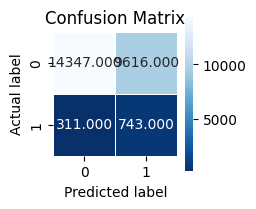

<Figure size 500x500 with 0 Axes>

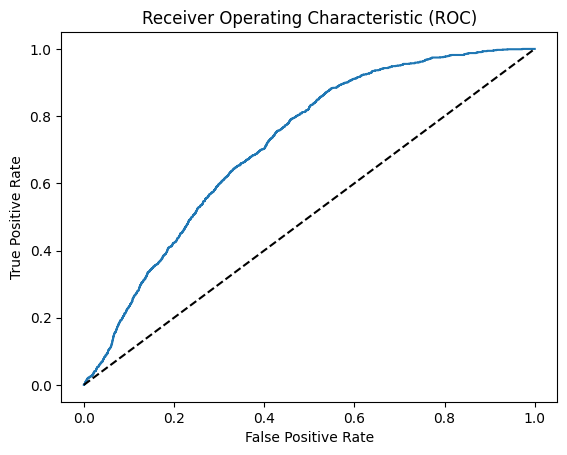

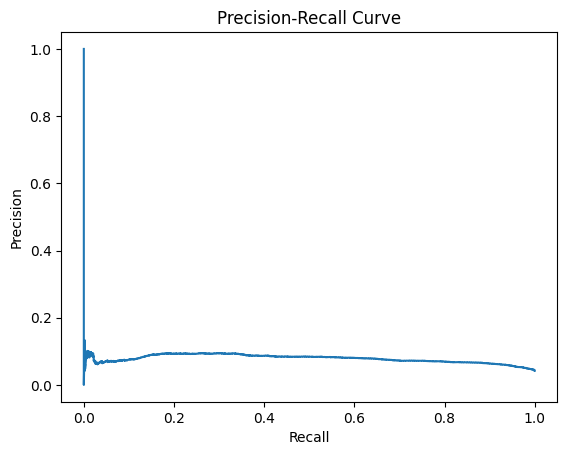

In [23]:
LR_classifier_means = LR(X_train_means_only, y_train, False)
result = predict(LR_classifier_means, id_test, X_test_means_only)
evaluate(y_test, result)

## 4.3 Model 1: Logistic Regression

In [24]:
# Logistic Regression Model
def LR(X_train,y_train, balance):
    '''
    Trains a Logistic Regression classifier on the provided training data with features with variance > 0.01 selected. 
    Optionally balances the training data with SMOTE if the `balance` parameter is set to True.

    Parameters:
    - X_train: The input features for the training dataset.
    - y_train: The target labels for the training dataset.
    - balance (bool): A flag indicating whether to balance the training data. If True, the training data will be balanced before training the classifier.

    Output:
    - classifier: The trained Logistic Regression classifier.
    '''

    
    if balance:
        X_train, y_train = balance_train_data(X_train, y_train)
    # remove low variance features
    # Define the pipeline with variance threshold selector and logistic regression classifier
    model = Pipeline([
        ('selector', VarianceThreshold(threshold=0.01)),
        ('classifier', LogisticRegression(max_iter=1000, verbose=1, random_state=123, class_weight='balanced'))
    ])
    # Train the model on X_train and y_train
    model.fit(X_train, y_train)
    return model

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.71112D+04    |proj g|=  1.40018D+05


 This problem is unconstrained.



At iterate   50    f=  5.10192D+04    |proj g|=  2.41164D+05

At iterate  100    f=  4.78449D+04    |proj g|=  1.03108D+05

At iterate  150    f=  4.66322D+04    |proj g|=  8.49795D+03

At iterate  200    f=  4.62309D+04    |proj g|=  3.61879D+03

At iterate  250    f=  4.61470D+04    |proj g|=  4.46139D+03

At iterate  300    f=  4.60638D+04    |proj g|=  4.59610D+03

At iterate  350    f=  4.60026D+04    |proj g|=  1.92071D+03

At iterate  400    f=  4.59618D+04    |proj g|=  6.26867D+03

At iterate  450    f=  4.58751D+04    |proj g|=  6.73146D+03

At iterate  500    f=  4.58196D+04    |proj g|=  2.35103D+03

At iterate  550    f=  4.57285D+04    |proj g|=  7.35018D+03

At iterate  600    f=  4.56342D+04    |proj g|=  2.10547D+04

At iterate  650    f=  4.55126D+04    |proj g|=  1.96263D+03

At iterate  700    f=  4.54130D+04    |proj g|=  1.66112D+03

At iterate  750    f=  4.53624D+04    |proj g|=  1.29707D+04

At iterate  800    f=  4.52483D+04    |proj g|=  5.47217D+03

At iter

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


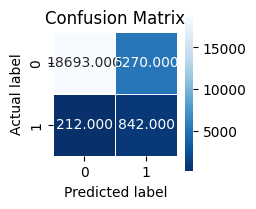

<Figure size 500x500 with 0 Axes>

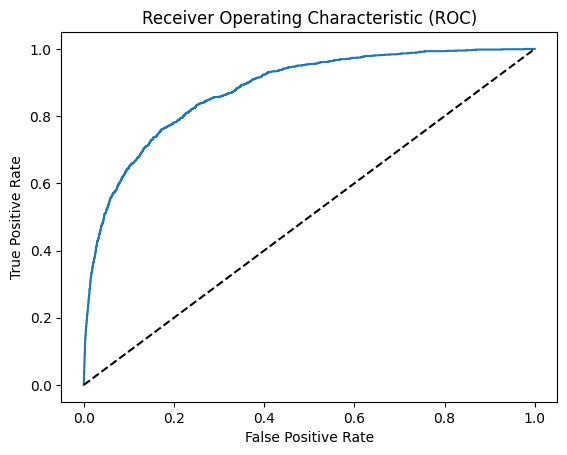

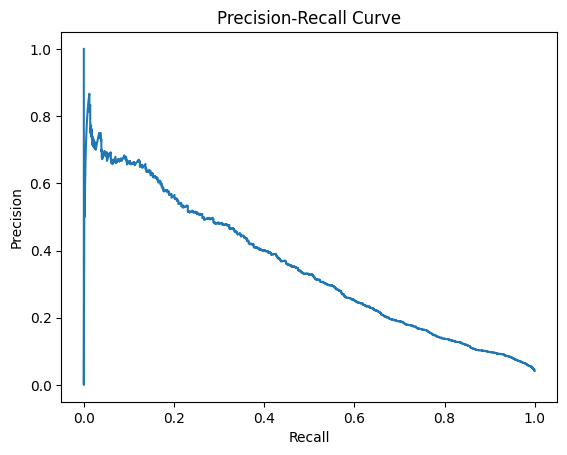

In [25]:
# ML workflow for Logistic Regression - without SMOTE
LR_classifier = LR(X_train, y_train, False)
result = predict(LR_classifier, id_test, X_test)
evaluate(y_test, result)

Label distribution before resampling:
label
0    92400
1     4421
Name: count, dtype: int64
Label distribution after resampling:
label
0    92400
1    92400
Name: count, dtype: int64
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28094D+05    |proj g|=  2.67538D+05


 This problem is unconstrained.



At iterate   50    f=  8.67367D+04    |proj g|=  1.33135D+05

At iterate  100    f=  7.81603D+04    |proj g|=  7.74476D+04

At iterate  150    f=  7.05678D+04    |proj g|=  8.47186D+04

At iterate  200    f=  6.08089D+04    |proj g|=  3.59631D+04

At iterate  250    f=  5.56653D+04    |proj g|=  6.53600D+04

At iterate  300    f=  5.17203D+04    |proj g|=  3.37984D+04

At iterate  350    f=  4.91005D+04    |proj g|=  4.58652D+03

At iterate  400    f=  4.87476D+04    |proj g|=  2.89942D+03

At iterate  450    f=  4.85657D+04    |proj g|=  1.56307D+04

At iterate  500    f=  4.84444D+04    |proj g|=  7.82669D+03

At iterate  550    f=  4.83373D+04    |proj g|=  3.09239D+03

At iterate  600    f=  4.82927D+04    |proj g|=  1.72423D+04

At iterate  650    f=  4.81793D+04    |proj g|=  1.57034D+04

At iterate  700    f=  4.81235D+04    |proj g|=  5.53754D+03

At iterate  750    f=  4.80715D+04    |proj g|=  3.27994D+03

At iterate  800    f=  4.78950D+04    |proj g|=  9.47117D+03

At iter

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


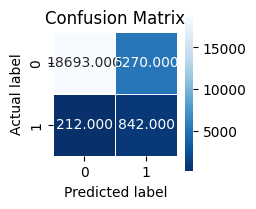

<Figure size 500x500 with 0 Axes>

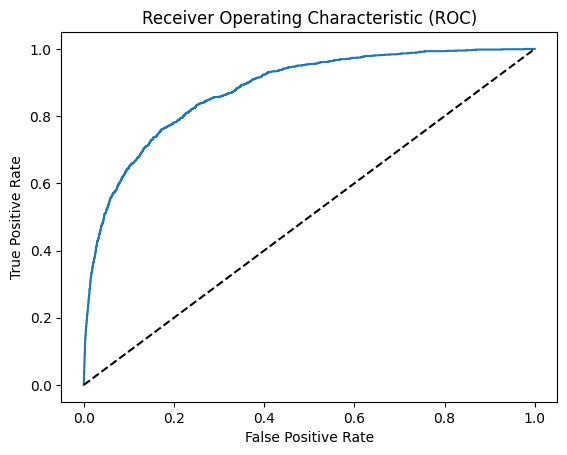

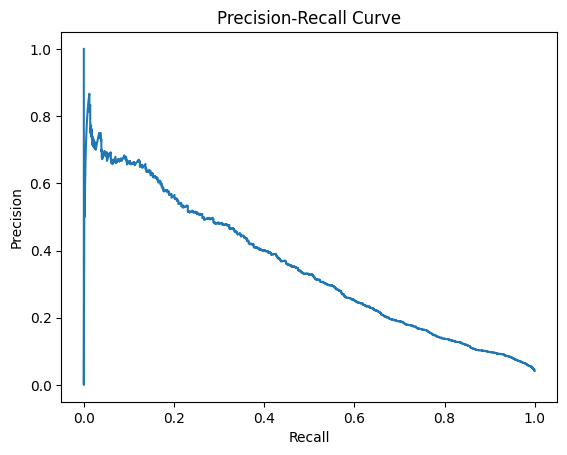

In [26]:
# ML workflow for Logistic Regression - with SMOTE
LR_classifier_balanced = LR(X_train, y_train,True)
result = predict(LR_classifier, id_test, X_test)
evaluate(y_test, result)


In [27]:
selection_mask= LR_classifier_balanced.named_steps['selector'].get_support()

# Create a DataFrame with feature names and selection status
feature_selection_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Selected': selection_mask
})

count_df = pd.Series(LR_classifier.named_steps['selector'].get_support()).value_counts().reset_index(name='Count').rename(columns={'index': 'Selected'})

print(feature_selection_df)
print(count_df)

                  Feature  Selected
0   -1_dwelling_time_mean     False
1    -1_dwelling_time_min     False
2    -1_dwelling_time_max     False
3    -1_standard_dev_mean      True
4    -1_mean_current_mean      True
5     -1_mean_current_min      True
6     -1_mean_current_max      True
7    0_dwelling_time_mean     False
8     0_dwelling_time_min     False
9     0_dwelling_time_max     False
10    0_standard_dev_mean      True
11    0_mean_current_mean      True
12     0_mean_current_min      True
13     0_mean_current_max      True
14  +1_dwelling_time_mean     False
15   +1_dwelling_time_min     False
16   +1_dwelling_time_max     False
17   +1_standard_dev_mean      True
18   +1_mean_current_mean      True
19    +1_mean_current_min      True
20    +1_mean_current_max      True
21                 pos1_A      True
22                 pos1_T      True
23                 pos1_C      True
24                 pos1_G      True
25                 pos2_A      True
26                 pos2_T   

## 4.4 Model 2: Random Forest

### 4.4.1 Baseline

In [28]:
def RF(X_train, y_train):
    '''
    Trains a Random Forest classifier on the provided training data.

    Parameters:
    - X_train: The input features for the training dataset.
    - y_train: The target labels for the training dataset.

    Output:
    - classifier: The trained Random Forest classifier.
    '''
    
    classifier = RandomForestClassifier(n_estimators=100, random_state=123, class_weight='balanced', verbose=1)
    classifier.fit(X_train, y_train)
    return classifier

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   10.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s



Tabulated Prediction Counts:
   prediction  count
0           0  92403
1           1   4418
Accuracy = 1.0
Balanced Accuracy = 1.0
f1 score = 1.0
Precision = 1.0
Recall = 0.999
ROC AUC = 1.0
PR AUC = 1.0


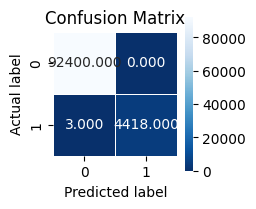

<Figure size 500x500 with 0 Axes>

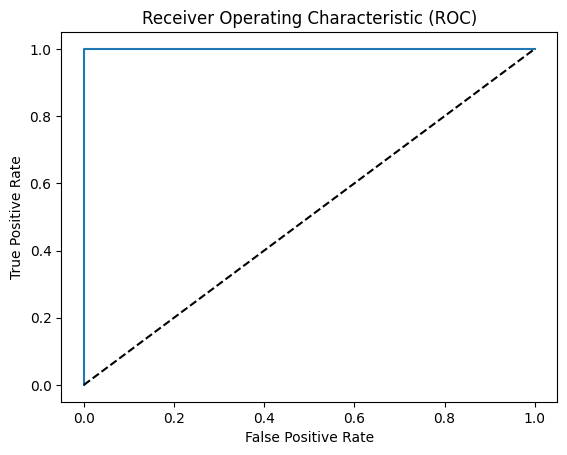

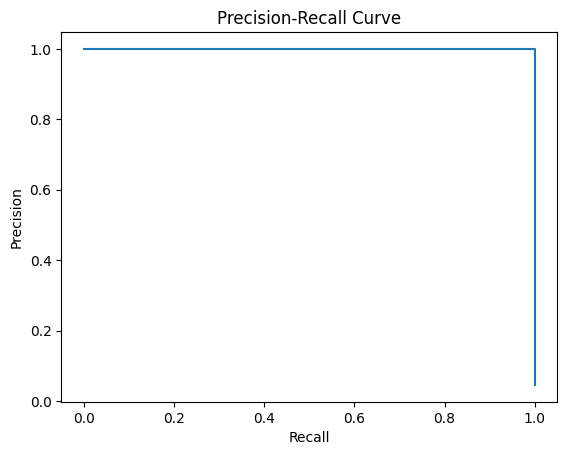

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s



Tabulated Prediction Counts:
   prediction  count
0           0  24781
1           1    236
Accuracy = 0.962
Balanced Accuracy = 0.579
f1 score = 0.262
Precision = 0.716
Recall = 0.16
ROC AUC = 0.902
PR AUC = 0.459


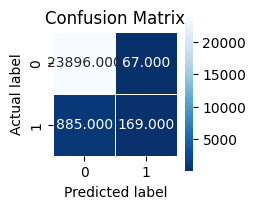

<Figure size 500x500 with 0 Axes>

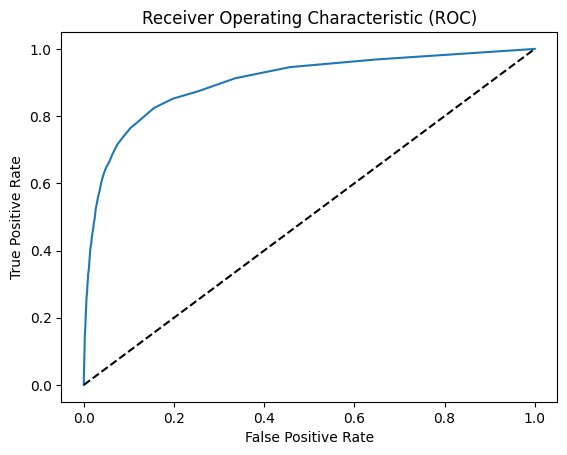

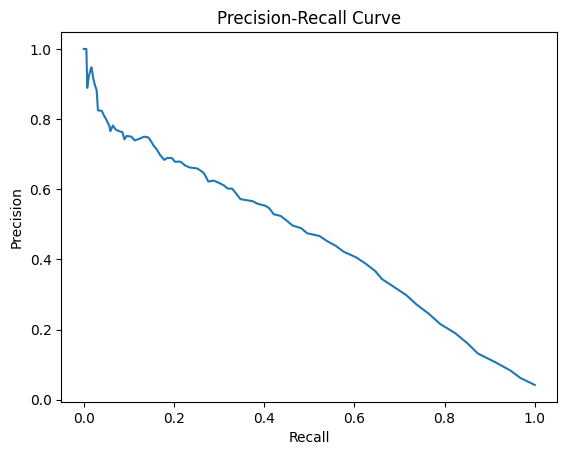

In [29]:
RF_classifier = RF(X_train, y_train)
result = predict(RF_classifier, id_test, X_train)
evaluate(y_train, result)
result = predict(RF_classifier, id_test, X_test)
evaluate(y_test, result)

### 4.4.2 Selector

In [30]:
def RF_tuning_feature_selection_RF(X_train, y_train):

    '''
    RF_tuning_feature_selection_RF uses SelectFromModel to select features with higher feature importance than median.
    This step was done before tuning due to the large number of features and high complexity of dataset to reduce training time.

    Inputs:
    - X_train
    - y_train

    Output:
    - selector_model: This model should be applied on X_train before further RF tuning. 
    
    '''

    # Step 1: Initialize RandomForestClassifier and fit for feature selection
    rf_temp = RandomForestClassifier(random_state=123, class_weight='balanced', n_estimators=50)
    selector_model = SelectFromModel(rf_temp, threshold="median")
    
    # Fit the selector model on training data
    selector_model.fit(X_train, y_train)
    
    # Get the boolean array indicating which features were kept
    feature_support = selector_model.get_support()
    
    # Get feature names from X_train (assuming it’s a DataFrame), otherwise create generic names
    feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]
    
    # Retrieve feature importances from the fitted RandomForestClassifier model
    feature_importances = selector_model.estimator_.feature_importances_
    
    # Create the DataFrame to show feature selection status and importance
    feature_df = pd.DataFrame({
        'Feature': feature_names,
        'Kept': feature_support,
        'Importance': feature_importances
    })

    feature_df = feature_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    
    # Display the DataFrame
    print(feature_df)
    
    return selector_model



In [31]:
selector = RF_tuning_feature_selection_RF(X_train, y_train)

                  Feature   Kept  Importance
0     0_mean_current_mean   True    0.091511
1     0_standard_dev_mean   True    0.088485
2    -1_mean_current_mean   True    0.058308
3      0_mean_current_min   True    0.052168
4    +1_mean_current_mean   True    0.051462
5     -1_mean_current_max   True    0.047225
6     +1_mean_current_min   True    0.045710
7    -1_standard_dev_mean   True    0.043413
8     -1_mean_current_min   True    0.042175
9                  pos2_G   True    0.040718
10    +1_mean_current_max   True    0.036777
11   0_dwelling_time_mean   True    0.035120
12                 pos6_T   True    0.034933
13   +1_standard_dev_mean   True    0.034358
14     0_mean_current_max   True    0.031168
15  +1_dwelling_time_mean   True    0.028969
16  -1_dwelling_time_mean   True    0.028856
17    0_dwelling_time_max   True    0.027163
18   -1_dwelling_time_max   True    0.026586
19   +1_dwelling_time_max   True    0.025930
20    0_dwelling_time_min   True    0.014682
21   -1_dw

In [32]:
# After defining RF_classifier
dump(selector, '../model/selector.joblib')  # Save the model

['../model/selector.joblib']

In [33]:
def select_features(X_train, selector):
    '''
    Transforms the training features by applying the specified feature selector, 
    retaining only the selected features.

    Parameters:
    - X_train: The input features for the training dataset.
    - selector: A fitted feature selector that defines which features to keep.

    Output:
    - X_train: The transformed training features containing only the selected features.
    '''
    
    X_train = selector.transform(X_train)
    
    return X_train

### 4.4.3 Tuning

In [65]:
def RF_tuning_intermediate(X_train, y_train, param_dist, selector):

    '''
    RF_tuning_intermediate uses RandomizedSearch to reduce search space
    with feature selection to improve efficiency. It also provides a
    DataFrame indicating which features were kept or removed.

    Parameters:
    - X_train: The input features for the training dataset.
    - y_train: The target labels for the training dataset.
    - param_dist: A dictionary defining the hyperparameter distribution 
      for RandomizedSearchCV.
    - selector: A fitted feature selector used to transform the input features.

    Output:
    - best_estimator: The best Random Forest classifier found by RandomizedSearchCV.
    - best_params: The best hyperparameters corresponding to the best estimator.
    '''

    X_train = select_features(X_train, selector)
    
    # Step 1: Define the main RandomForestClassifier for tuning
    model = RandomForestClassifier(random_state=123, class_weight='balanced')

    # Custom combined AUC score
    def combined_auc_score(y_true, y_pred_proba):
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        pr_auc = average_precision_score(y_true, y_pred_proba)
        return 0.3 * roc_auc + 0.7 * pr_auc

    # Create custom scorer
    custom_scorer = make_scorer(combined_auc_score, needs_proba=True)

    # Step 2: Set up RandomizedSearchCV
    randomized_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=30,  
        scoring=custom_scorer,
        cv=5,      
        n_jobs=-1,
        verbose=1,
        random_state=123
    )
    
    # Train the model using RandomizedSearchCV
    randomized_search.fit(X_train, y_train)
    
    return randomized_search

def plot_randomized_search_tuning_results(randomized_search):
    """
    Plots the hyperparameter tuning results for each parameter in the randomized search.
    
    Parameters:
    - randomized_search: The fitted RandomizedSearchCV object after performing hyperparameter tuning.
    """
    # Convert randomized search results to DataFrame
    results = pd.DataFrame(randomized_search.cv_results_)
    
    # Extract the mean test score and parameters tested
    scores = results['mean_test_score']
    params = results['params']

    # For each parameter in the distribution, create a plot
    for param in randomized_search.param_distributions.keys():
        # Extract values for the current parameter
        param_values = [p[param] for p in params]
        
        # Plot the parameter against the scores
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=param_values, y=scores)
        
        plt.title(f'Hyperparameter Tuning Results for {param}')
        plt.xlabel(param)
        plt.ylabel('Combined AUC Score')
        plt.grid(True)
        plt.show()

Hyperparameter tuning was run previously, but output was not saved. The following steps were done:
- Hyperparameters were tested using RandomSearch
- Train metrics were checked in ROC-AUC and PR-AUC were too close to 1, overfitting has occurred, changes were made to hyperparameters to decrease complexity. This happened when None is selected for `max_depth`, so None was excluded as an option
- If train metrics went too low (below test accuracy of baseline), underfitting suspected, changes were made to hyperparameters to increase complexity.
- In particular, to increase complexity:
  - increase `n_estimators`
  - increase `max_depth`
  - increase `max_leaf_nodes`
  - decrease `min_samples_split`
  - decrease `min_samples_leaf`
- Perform the reverse to decrease complexity

The below shows some of the final hyperparameters involved in the test and demonstrates tuning change based on the result of the first test

In [66]:
param_dist_search_1 = {
            'n_estimators': [100, 250, 500, 1000],  
            'max_depth': [10, 25, 50],  
            'max_leaf_nodes': [10, 100, 1000],
            'min_samples_split': [2, 5, 10], 
            'min_samples_leaf': [2, 5, 10],
    
        }    
RF_search_1 = RF_tuning_intermediate(X_train, y_train, param_dist_search_1, selector)
RF_search_1_classifier = RF_search_1.best_estimator_
RF_search_1_params = RF_search_1.best_params_
print(f'Tuning step 1 outputs: {RF_search_1_params}')

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Tuning step 1 outputs: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_leaf_nodes': 1000, 'max_depth': 50}



Tabulated Prediction Counts:
   prediction  count
0           0  89337
1           1   7484
Accuracy = 0.965
Balanced Accuracy = 0.961
f1 score = 0.711
Precision = 0.566
Recall = 0.958
ROC AUC = 0.988
PR AUC = 0.725


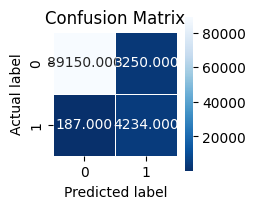

<Figure size 500x500 with 0 Axes>

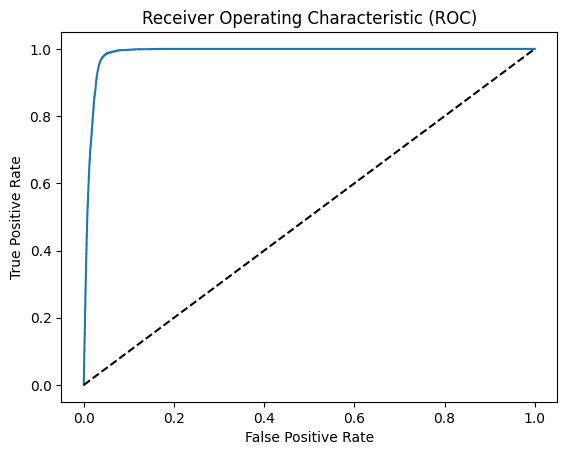

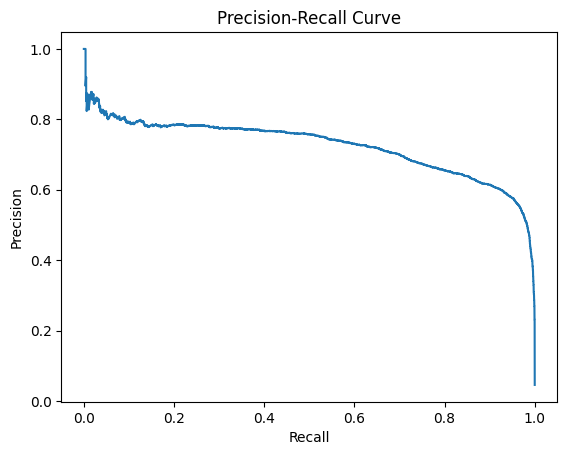

In [67]:
# Tuning 1 results - train
X_train_selected = select_features(X_train,selector)
result = predict(RF_search_1_classifier, id_train, X_train_selected)
evaluate(y_train, result)

# ROC AUC = 0.988, PR AUC = 0.725
# ROC AUC rather close to 1, but PR AUC is alright. May be some overfitting as train performs better than test
# Try some hyperparameters in final steps to reduce overfitting


Tabulated Prediction Counts:
   prediction  count
0           0  23440
1           1   1577
Accuracy = 0.944
Balanced Accuracy = 0.774
f1 score = 0.471
Precision = 0.393
Recall = 0.587
ROC AUC = 0.906
PR AUC = 0.447


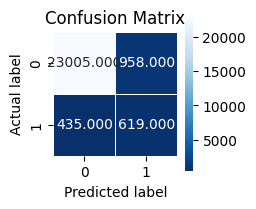

<Figure size 500x500 with 0 Axes>

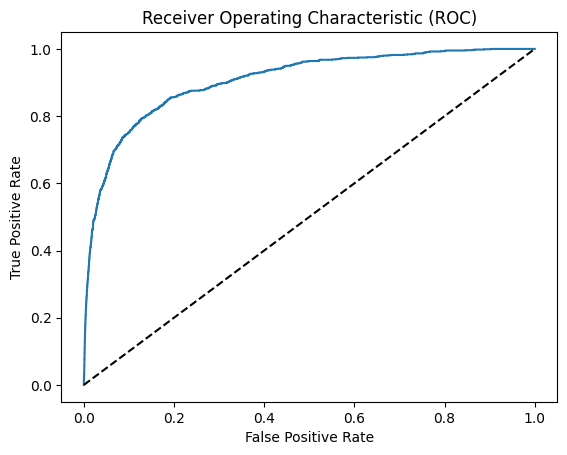

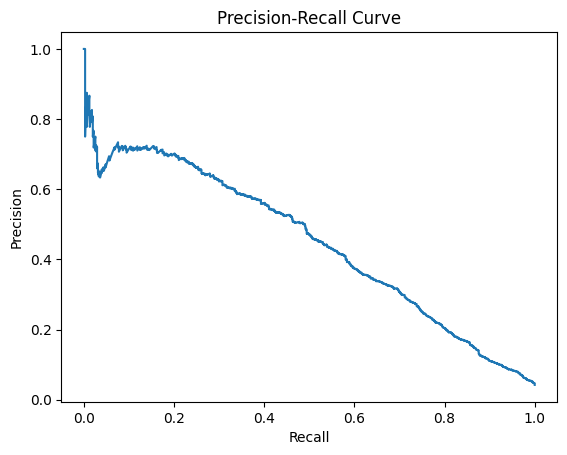

In [68]:
# Tuning 1 results - test
X_test_selected = select_features(X_test,selector)
result = predict(RF_search_1_classifier, id_test, X_test_selected)
evaluate(y_test, result)

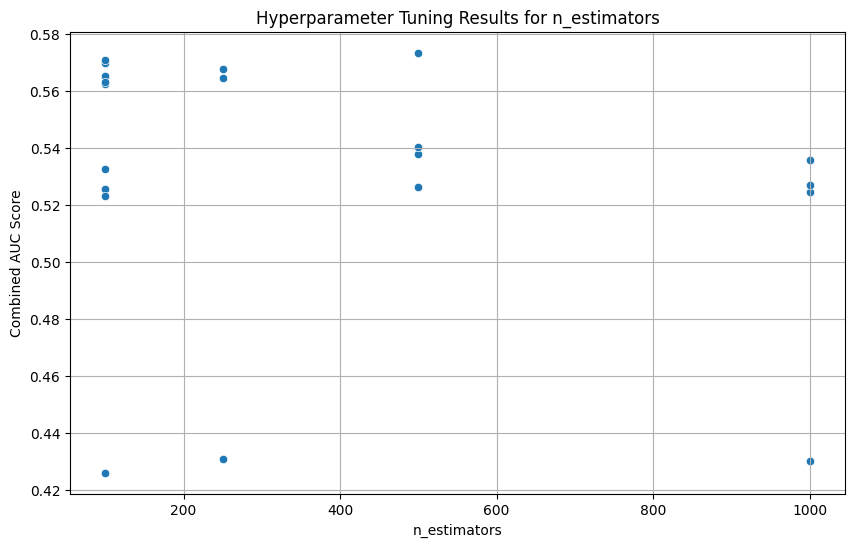

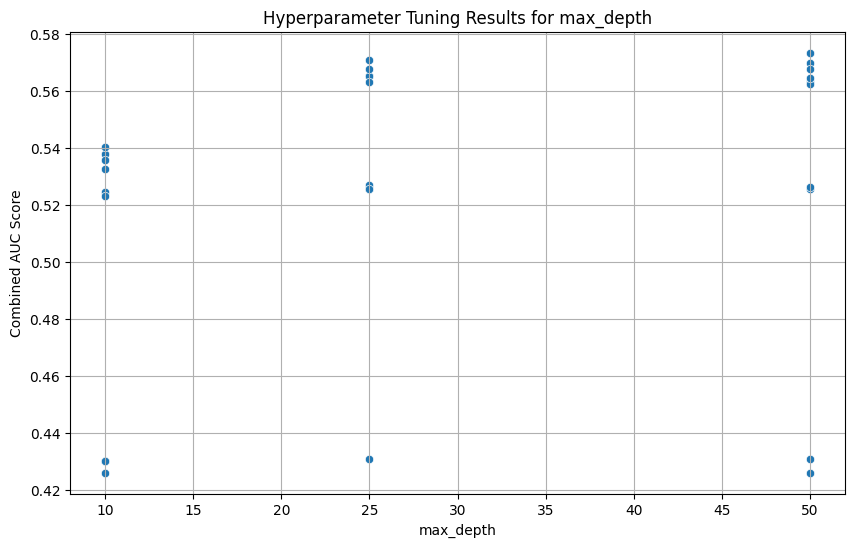

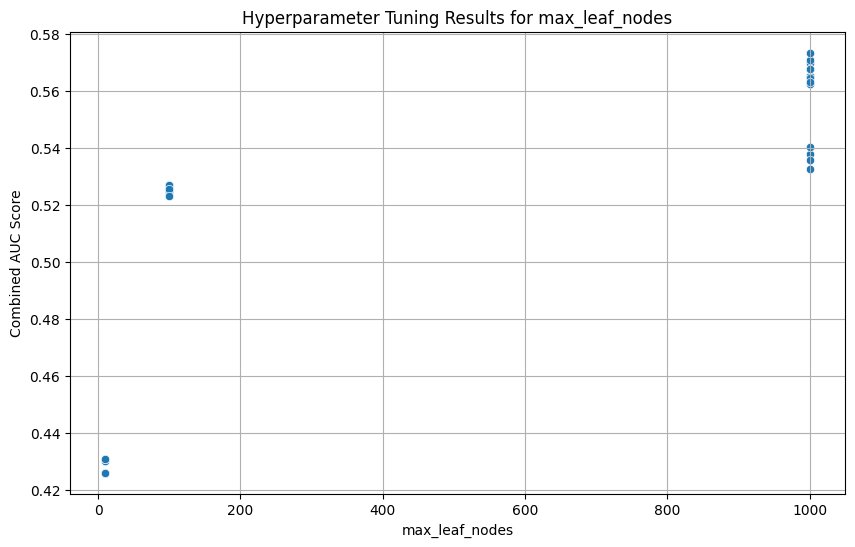

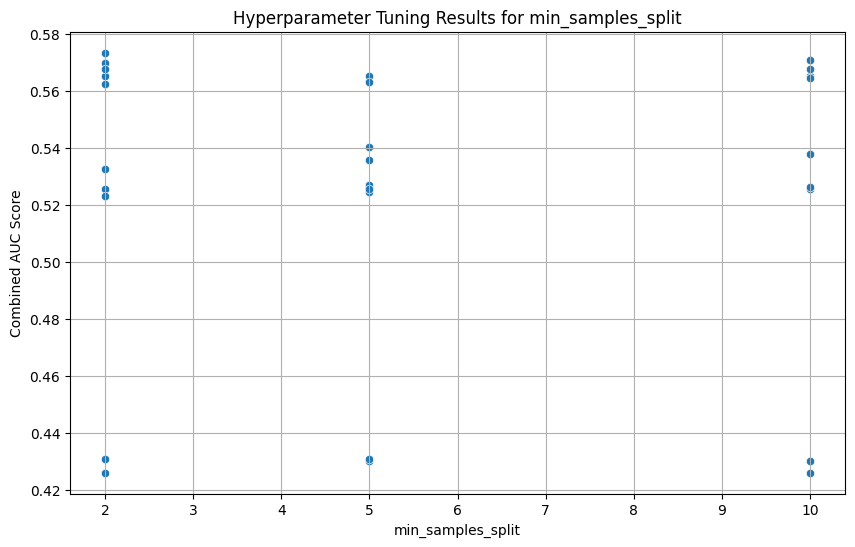

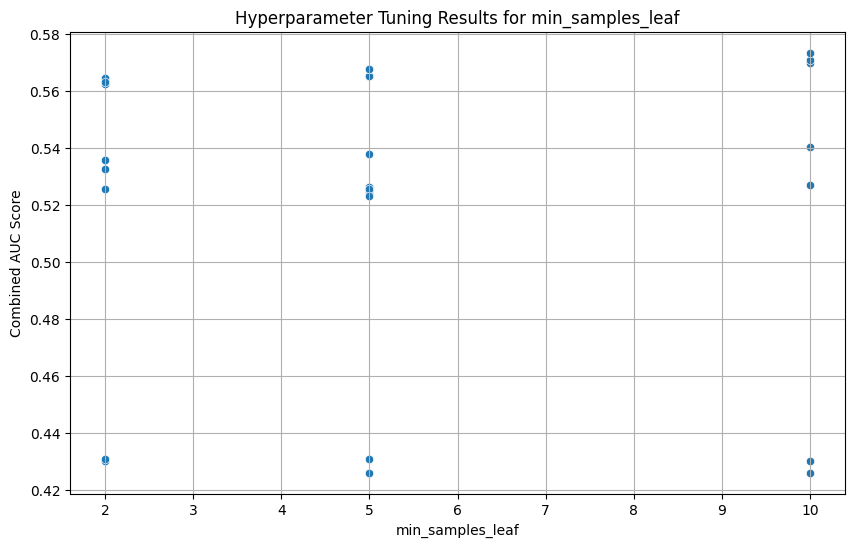

In [69]:
plot_randomized_search_tuning_results(RF_search_1)

In [70]:
# search 1: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_leaf_nodes': 1000, 'max_depth': 50}
# seek to reduce complexity
# for n_estimators, max_depth and max_leaf_nodes, choose hyperparams <= search 1's params
# for min_samples_split and min_samples_leaf, choose hyperparams >= search 1's params

param_dist_search_2 = {
            'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500],
            'max_depth': [20, 25, 30, 35, 40, 45, 50], 
            'max_leaf_nodes': [200, 300, 400, 500, 600, 700, 800, 900, 1000], 
            'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
            'min_samples_leaf': [10, 15, 20, 25, 30]
}
RF_search_2 = RF_tuning_intermediate(X_train, y_train, param_dist_search_2, selector)
RF_search_2_classifier = RF_search_2.best_estimator_
RF_search_2_params = RF_search_2.best_params_
print(f'Tuning step 2 outputs: {RF_search_2_params}')

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Tuning step 2 outputs: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 15, 'max_leaf_nodes': 1000, 'max_depth': 20}



Tabulated Prediction Counts:
   prediction  count
0           0  89266
1           1   7555
Accuracy = 0.962
Balanced Accuracy = 0.952
f1 score = 0.694
Precision = 0.55
Recall = 0.94
ROC AUC = 0.987
PR AUC = 0.72


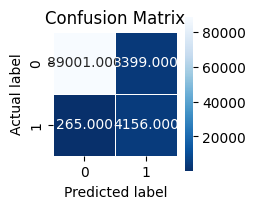

<Figure size 500x500 with 0 Axes>

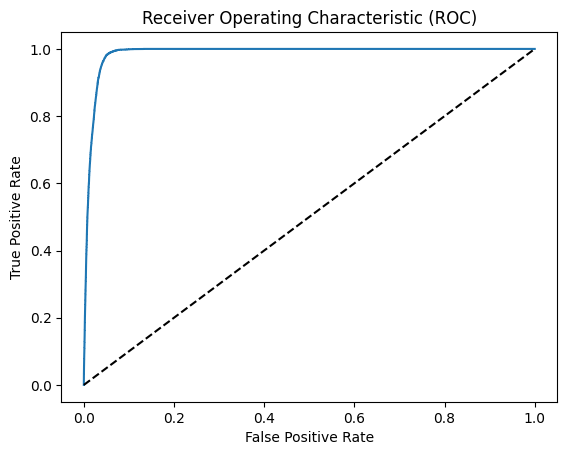

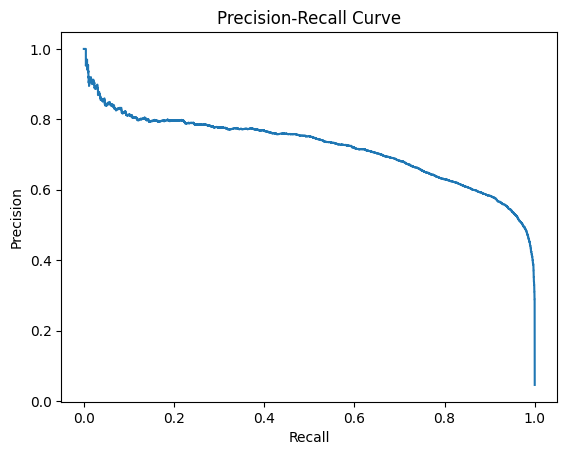

In [71]:
# Tuning 2 results - train
X_train_selected = select_features(X_train,selector)
result = predict(RF_search_2_classifier, id_train, X_train_selected)
evaluate(y_train, result)

# note: exactly the same parameters obtained except min_samples_split 
# move to final grid search


Tabulated Prediction Counts:
   prediction  count
0           0  23370
1           1   1647
Accuracy = 0.942
Balanced Accuracy = 0.778
f1 score = 0.466
Precision = 0.383
Recall = 0.598
ROC AUC = 0.907
PR AUC = 0.447


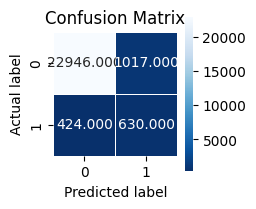

<Figure size 500x500 with 0 Axes>

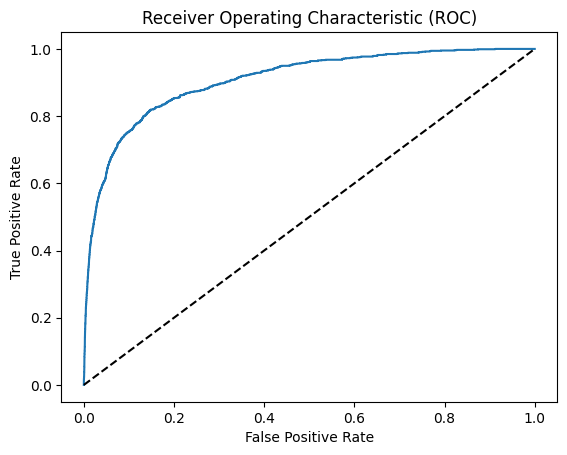

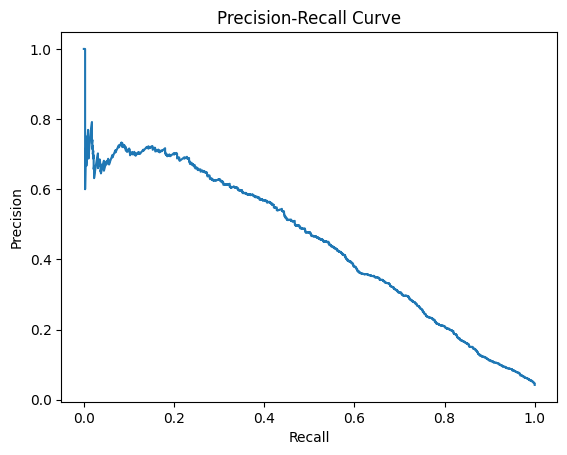

In [72]:
# Tuning 2 results - test
X_test_selected = select_features(X_test,selector)
result = predict(RF_search_2_classifier, id_test, X_test_selected)
evaluate(y_test, result)

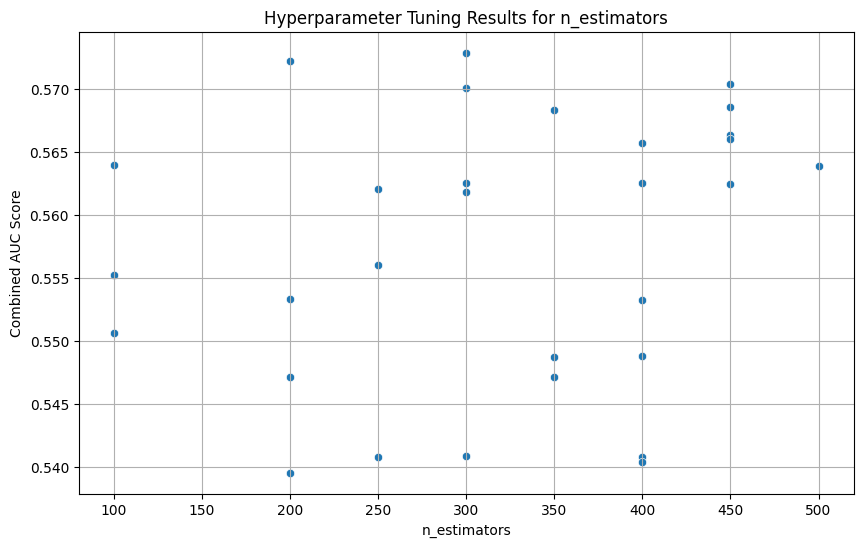

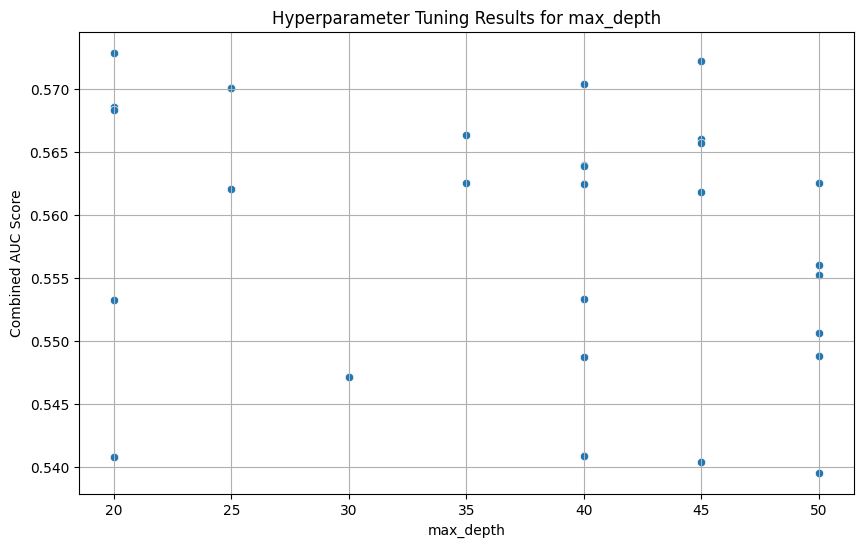

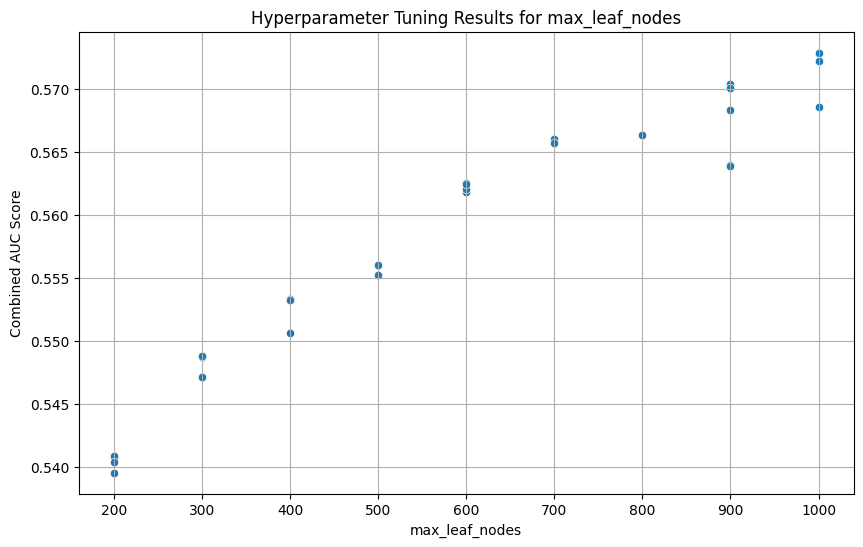

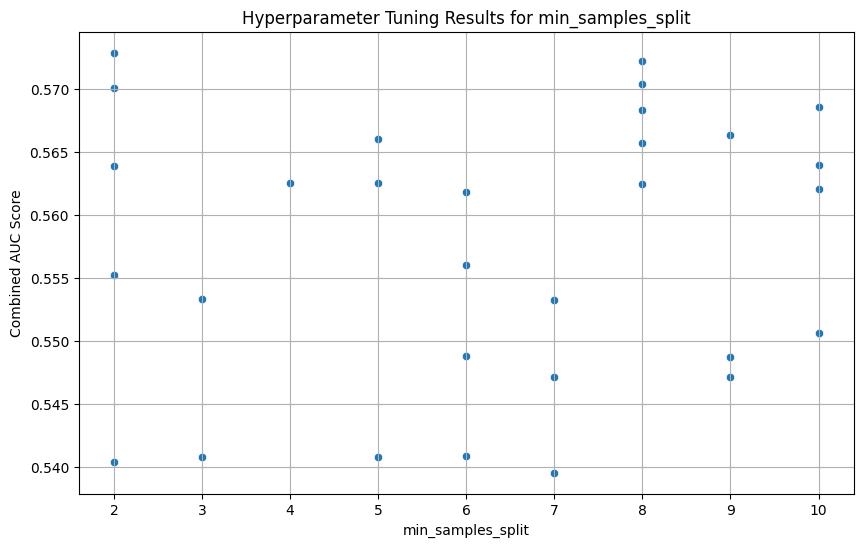

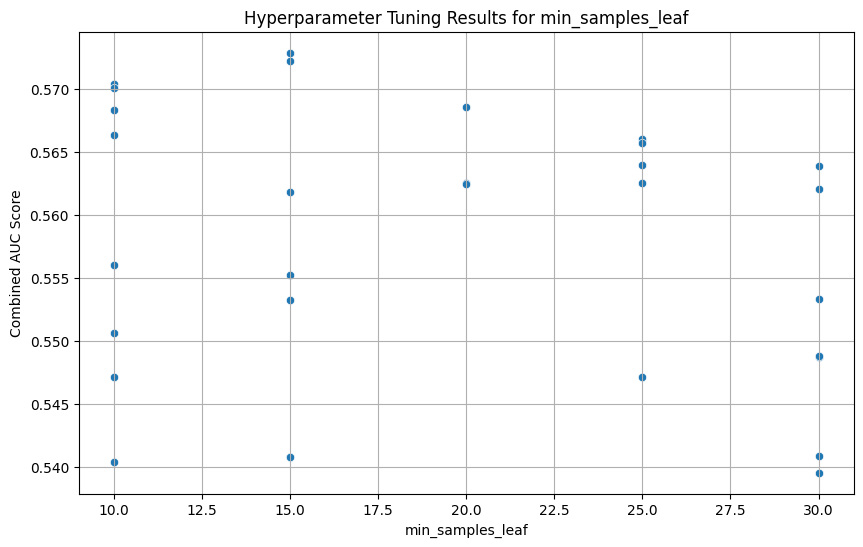

In [73]:
plot_randomized_search_tuning_results(RF_search_2)

### 4.4.4 Final Tuning

In [75]:
def RF_tuning_final(X_train, y_train, param_grid, selector):
    '''
    RF_tuning uses GridSearch on an exhaustive list of parameters, determined after GridSearch

    
    Parameters:
    - X_train: The input features for the training dataset.
    - y_train: The target labels for the training dataset.
    - param_grid: A dictionary defining the hyperparameter grid for GridSearchCV.
    - selector: A fitted feature selector used to transform the input features.

    Output:
    - best_estimator: The best Random Forest classifier found by GridSearchCV.
    - best_params: The best hyperparameters corresponding to the best estimator.
    '''   
    X_train = select_features(X_train, selector)

    # Define the random forest model with class_weight set to 'balanced'
    model = RandomForestClassifier(random_state=123, class_weight='balanced')

    # Custom scoring function combining ROC AUC and PR AUC
    def combined_auc_score(y_true, y_pred_proba):
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        pr_auc = average_precision_score(y_true, y_pred_proba)
    
        # Combined score
        combined_score = 0.3 * roc_auc + 0.7 * pr_auc # prioritise pr_auc due to imbalanced data
        return combined_score

    # Create a custom scorer using make_scorer
    custom_scorer = make_scorer(combined_auc_score, needs_proba=True)

    # Set up GridSearchCV with the parameter grid
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               scoring=custom_scorer, cv=5, n_jobs=-1, verbose=1)
    
    # Train the model on X_train and y_train using GridSearchCV
    grid_search.fit(X_train, y_train)

    return grid_search

def plot_hyperparameter_tuning_results(grid_search):
    """
    Plots the hyperparameter tuning results for each parameter in the grid.
    
    Parameters:
    - grid_search: The fitted GridSearchCV object after performing hyperparameter tuning.
    """
    # Convert grid search results to DataFrame
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Extract the mean test score and parameters tested
    scores = results['mean_test_score']
    params = results['params']

    # For each parameter in the grid, create a plot
    for param in grid_search.param_grid.keys():
        # Extract values for the current parameter
        param_values = [p[param] for p in params]
        
        # Plot the parameter against the scores
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=param_values, y=scores)
        
        plt.title(f'Hyperparameter Tuning Results for {param}')
        plt.xlabel(param)
        plt.ylabel('Combined AUC Score')
        plt.grid(True)
        plt.show()

In [76]:
# step 2 outputs: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 15, 'max_leaf_nodes': 1000, 'max_depth': 20}
# based on graph, it seems like increasing max_leaf_nodes increase metrics, but other hyperparams do not, so we keep that at max
# try a lower value for other hyperparameters to reduce complexity
param_grid_final = {
            'n_estimators': [200], # looks quite random from 200 onwards, pick 200
            'max_depth': [10, 20], # looks quite random, try a lower value
            'max_leaf_nodes': [1000], # param that affects score the most, maintain complexity
            'min_samples_split': [10, 20], # looks quite random throughout, try higher
            'min_samples_leaf': [15, 20], # some influence 
            'bootstrap': [True], # use True to train each tree on a random subset of original data
            'max_features': ['sqrt', 'log2'] # new
        }   
RF_tuned = RF_tuning_final(X_train, y_train, param_grid_final, selector)
RF_tuned_classifier = RF_tuned.best_estimator_
RF_tuned_params = RF_tuned.best_params_
print(f'Final classifier: {RF_tuned_params}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Final classifier: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': 1000, 'min_samples_leaf': 15, 'min_samples_split': 10, 'n_estimators': 200}


In [ ]:
# Final classifier: 
# old: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 1000, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 500}

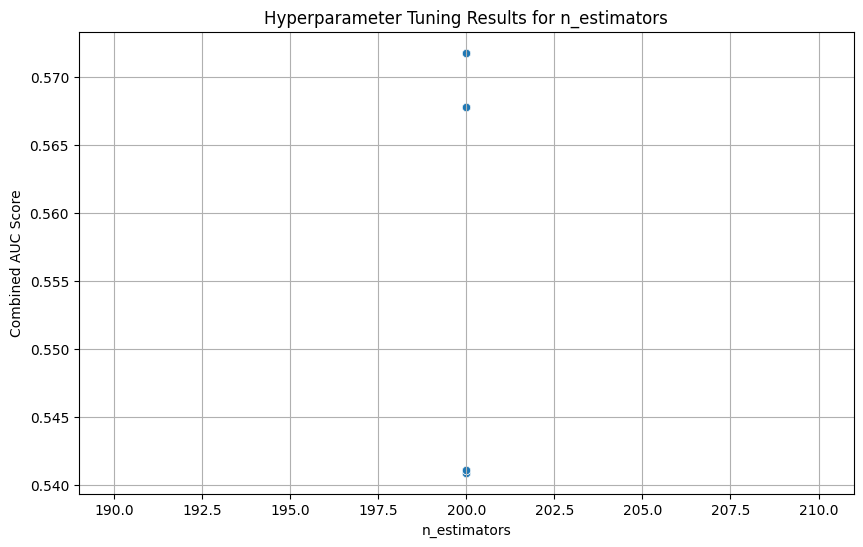

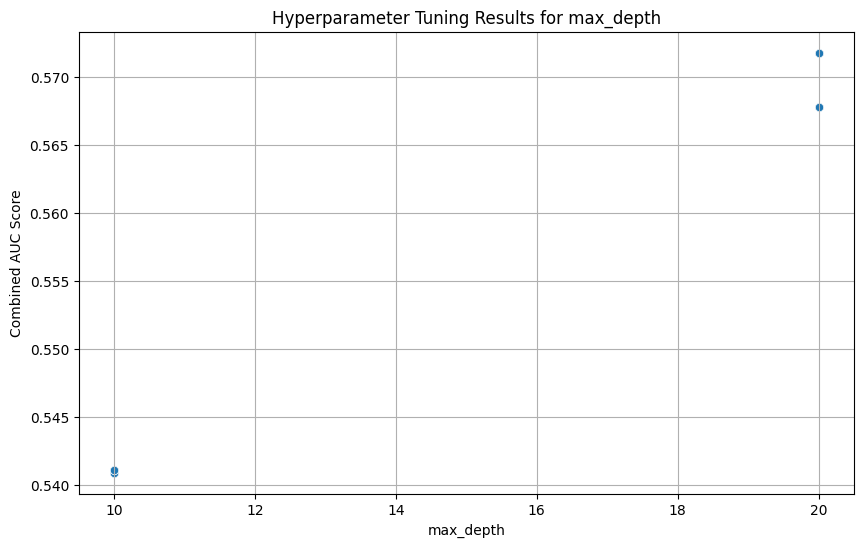

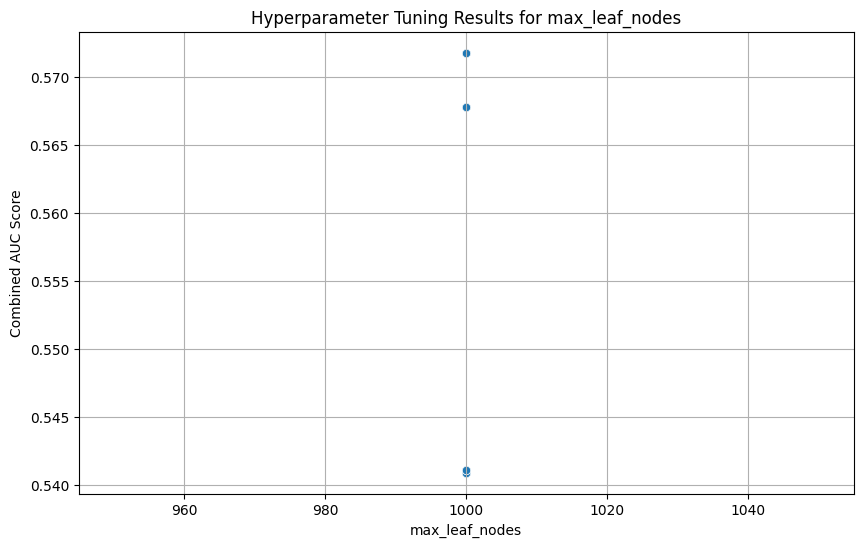

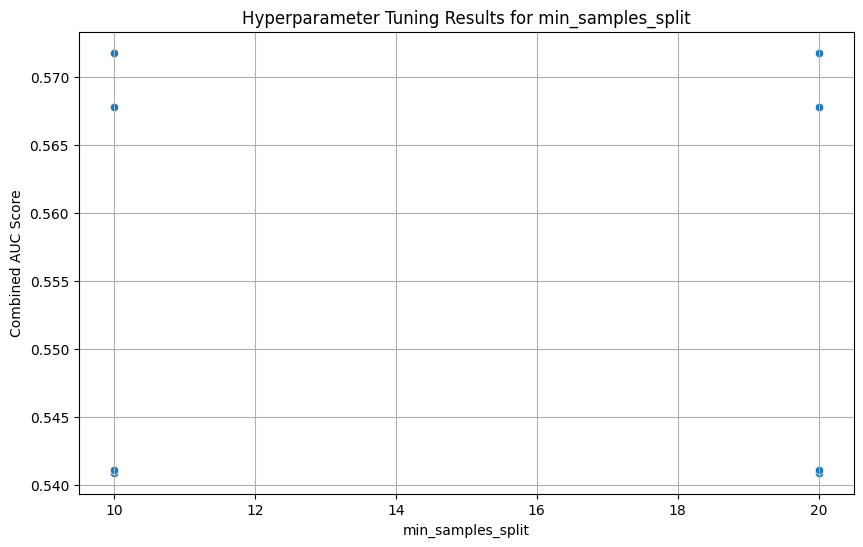

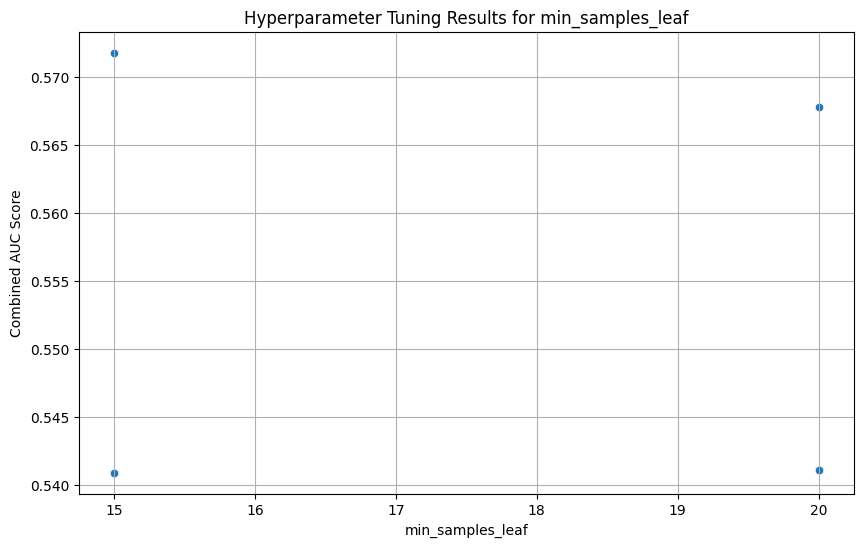

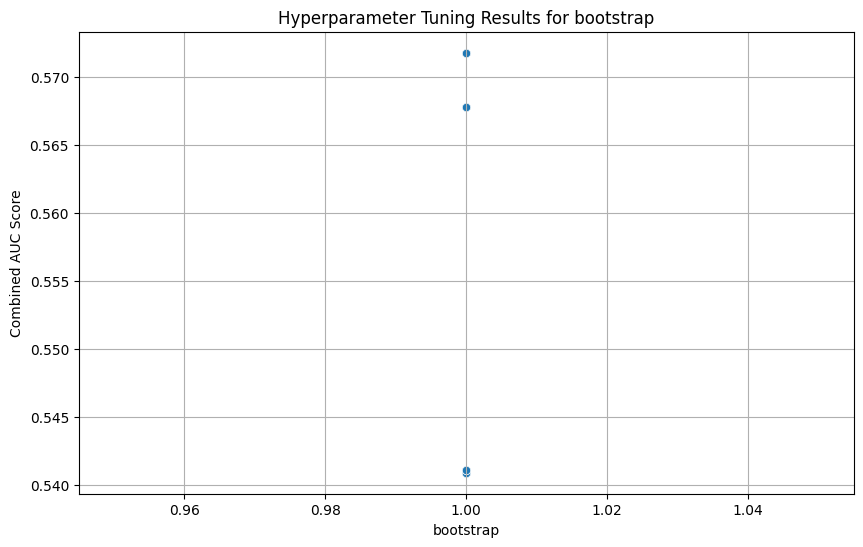

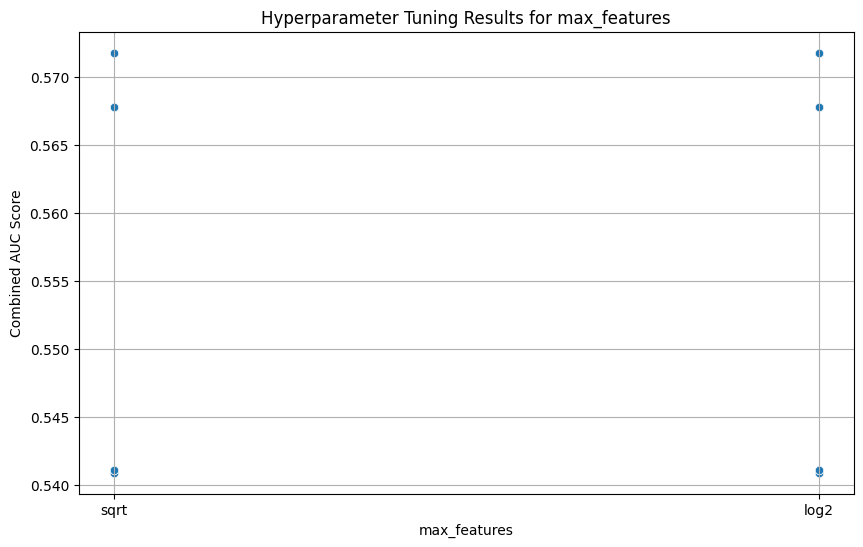

In [78]:
plot_hyperparameter_tuning_results(RF_tuned)

In [120]:
def RF_with_final_params():
    '''
    Trains a Random Forest classifier on the provided training data.

    Parameters:
    - X_train: The input features for the training dataset.
    - y_train: The target labels for the training dataset.

    Output:
    - classifier: The trained Random Forest classifier.
    '''
    final_params = {
        'bootstrap': True,
        'max_depth': 20, 
        'max_features': 'log2', # not much difference, pick lower value to reduce complexity
        'max_leaf_nodes': 1000,
        'min_samples_leaf': 15, 
        'min_samples_split': 20, # not much difference, pick higher value to reduce complexity
        'n_estimators': 200
    }
    classifier = RandomForestClassifier(**final_params, random_state=123, class_weight='balanced', verbose=1)
    return classifier

In [121]:
# Compare train and test results with and without SMOTE
# With SMOTE
X_train_balanced, y_train_balanced = balance_train_data(X_train, y_train)
X_train_balanced_selected = select_features(X_train_balanced,selector)
RF_final_with_SMOTE = RF_with_final_params()
RF_final_with_SMOTE.fit(X_train_balanced_selected, y_train_balanced)

Label distribution before resampling:
label
0    92400
1     4421
Name: count, dtype: int64
Label distribution after resampling:
label
0    92400
1    92400
Name: count, dtype: int64


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   29.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  2.0min


RandomForestClassifier(class_weight='balanced', max_depth=20,
                       max_features='log2', max_leaf_nodes=1000,
                       min_samples_leaf=15, min_samples_split=20,
                       n_estimators=200, random_state=123, verbose=1)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.8s



Tabulated Prediction Counts:
   prediction  count
0           0  88128
1           1   8693
Accuracy = 0.94
Balanced Accuracy = 0.884
f1 score = 0.554
Precision = 0.418
Recall = 0.822
ROC AUC = 0.964
PR AUC = 0.594


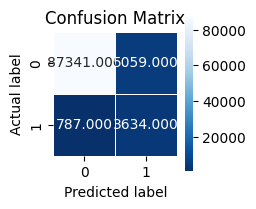

<Figure size 500x500 with 0 Axes>

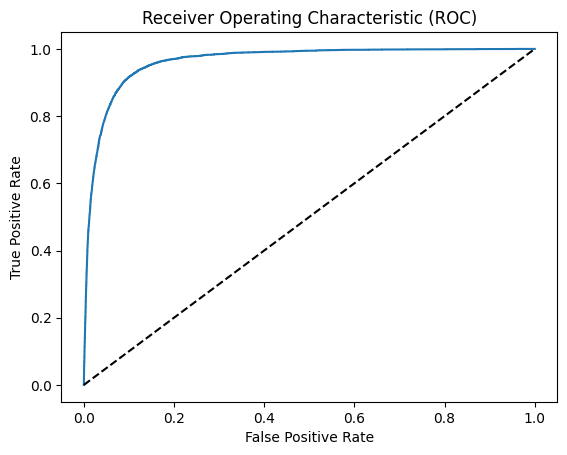

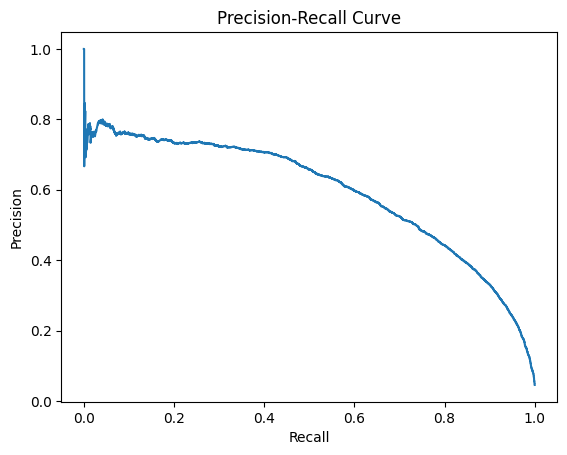

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s



Tabulated Prediction Counts:
   prediction  count
0           0  22776
1           1   2241
Accuracy = 0.924
Balanced Accuracy = 0.801
f1 score = 0.426
Precision = 0.313
Recall = 0.666
ROC AUC = 0.901
PR AUC = 0.416


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


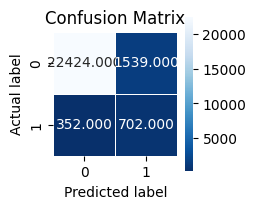

<Figure size 500x500 with 0 Axes>

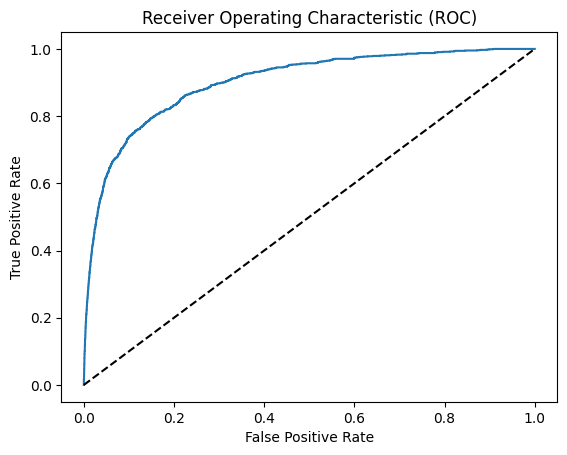

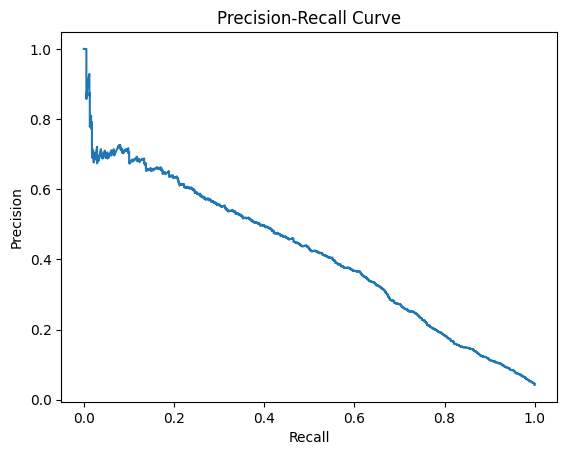

In [122]:
# Final train and results with SMOTE
result = predict(RF_final_with_SMOTE, id_train, X_train_selected)
evaluate(y_train, result)

result = predict(RF_final_with_SMOTE, id_test, X_test_selected)
evaluate(y_test, result)

In [123]:
# Without SMOTE
X_train_selected = select_features(X_train,selector)
RF_final_without_SMOTE = RF_with_final_params()
RF_final_without_SMOTE.fit(X_train_selected, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   44.3s


RandomForestClassifier(class_weight='balanced', max_depth=20,
                       max_features='log2', max_leaf_nodes=1000,
                       min_samples_leaf=15, min_samples_split=20,
                       n_estimators=200, random_state=123, verbose=1)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.9s



Tabulated Prediction Counts:
   prediction  count
0           0  89235
1           1   7586
Accuracy = 0.962
Balanced Accuracy = 0.952
f1 score = 0.693
Precision = 0.548
Recall = 0.941
ROC AUC = 0.987
PR AUC = 0.72


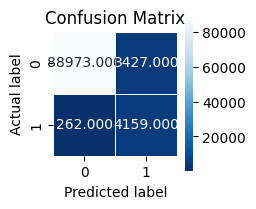

<Figure size 500x500 with 0 Axes>

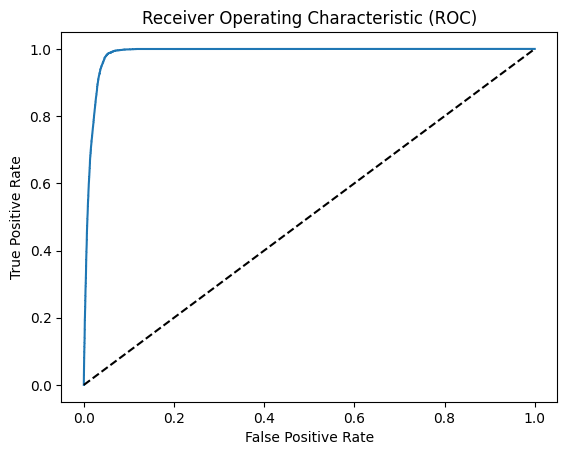

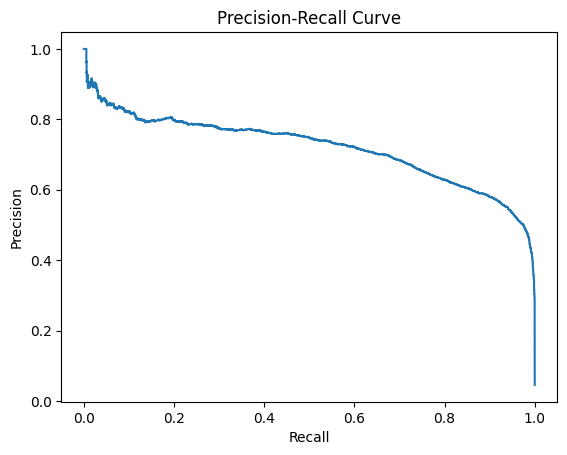

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s



Tabulated Prediction Counts:
   prediction  count
0           0  23357
1           1   1660
Accuracy = 0.942
Balanced Accuracy = 0.776
f1 score = 0.463
Precision = 0.378
Recall = 0.596
ROC AUC = 0.907
PR AUC = 0.446


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


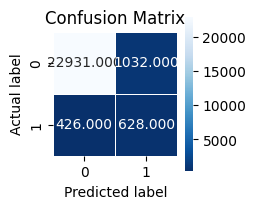

<Figure size 500x500 with 0 Axes>

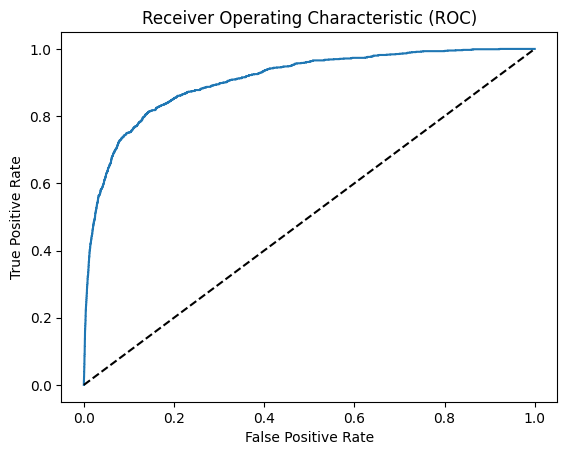

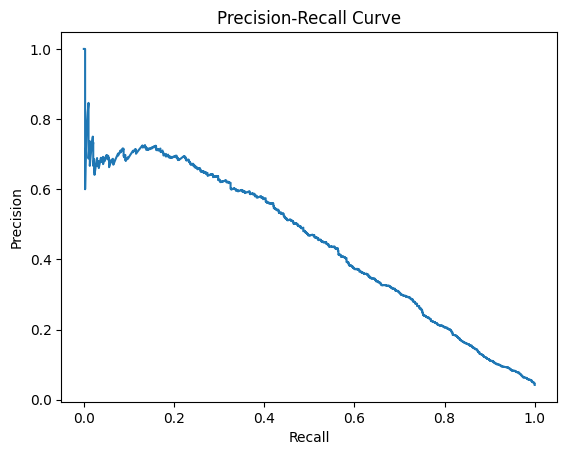

In [124]:
result = predict(RF_final_without_SMOTE, id_train, X_train_selected)
evaluate(y_train, result)

result = predict(RF_final_without_SMOTE, id_test, X_test_selected)
evaluate(y_test, result)

** Final results **
- With SMOTE:
    - Train: ROC AUC = 0.964, PR AUC = 0.594
    - Test: ROC AUC = 0.901, PR AUC = 0.416
- Without SMOTE:
    - Train: ROC AUC = 0.987, PR AUC = 0.72
    - Test: ROC AUC = 0.907, PR AUC = 0.446

All metrics are better without SMOTE, so we will keep these metrics

# Final Model - Random Forest: Train using all the data

In [125]:
def load_model(job_lib_file): 
    '''
    Loads a pre-trained model from a specified joblib file.

    Parameters:
    - job_lib_file: The path to the joblib file containing the saved model.

    Output:
    - classifier: The loaded pre-trained model.
    '''

    # Load the model
    classifier = load(job_lib_file)

    return classifier

In [126]:
def get_X_y_id(features_labelled):
    '''
    For training function, split features_labelled into X, y and id columns

    Parameters:
    - features_labelled

    Output: 
    - X
    - y
    - features_labelled
    
    '''

    y = features_labelled['label']
    id = features_labelled[['transcript_id','transcript_position']]
    X = features_labelled.drop(columns = ['transcript_id', 'transcript_position', 'gene_id', 'label'])
    return X, y, id

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   13.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   56.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.3s



Tabulated Prediction Counts:
   prediction   count
0           0  111221
1           1   10617
Accuracy = 0.951
Balanced Accuracy = 0.94
f1 score = 0.631
Precision = 0.478
Recall = 0.927
ROC AUC = 0.983
PR AUC = 0.668


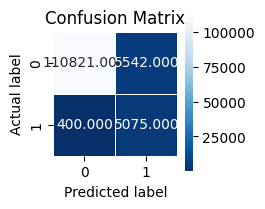

<Figure size 500x500 with 0 Axes>

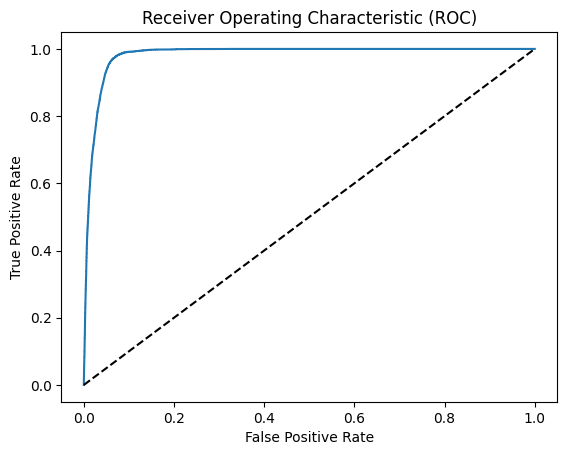

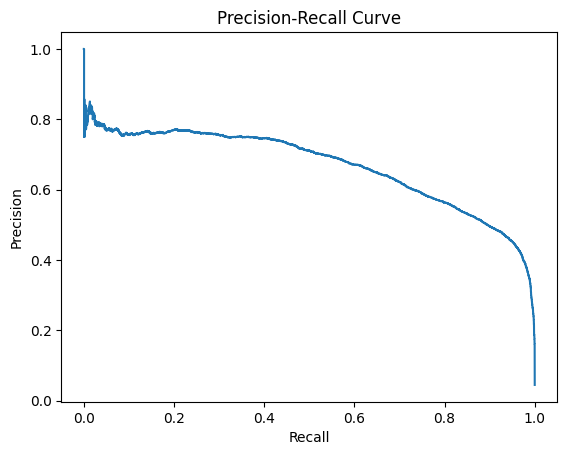

In [128]:
X, y, id = get_X_y_id(features_labelled)
X_selected = select_features(X,selector)
RF_final_classifer = RF_with_final_params()
RF_final_classifier.fit(X_selected, y)
result = predict(RF_final_classifier, id, X_selected)
evaluate(y, result)

In [129]:
def generate_model(training_data_json_file, labels_file, selector_file, output_joblib_path, compress=True):
    json_file = unzip_file(training_data_json_file)
    features = flatten_json(json_file)
    labels = read_labels(labels_file)
    print("Step 1/6: Processing JSON and labels completed.")
    
    features_agg = aggregate_by_transcript_position(features)
    features_agg_with_seq = one_hot_encode_sequence(features_agg)
    print("Step 2/6: Features engineering completed.")

    features_labelled = add_gene_and_label(features_agg_with_seq, labels)
    X, y, id = get_X_y_id(features_labelled)
    print("Step 3/6: X, y and id generated")
    
    selector = load_model(selector_file)
    X_selected = select_features(X, selector)
    print("Step 4/6: Feature selection completed.")

    # params from tuning stage
    RF_final_classifier = RF_with_final_params()
    RF_final_classifier.fit(X_selected, y)
    print("Step 5/6: Fitting classifier completed.")
        
    dump(RF_final_classifier, output_joblib_path)
    print(f"Step 6/6: Model written to {output_joblib_path}")

    if compress:
        with open(output_joblib_path, 'rb') as f_in:
            with gzip.open(f'{output_joblib_path}.gz', 'wb') as f_out:
                f_out.writelines(f_in)
        print(f"Model compressed to {output_joblib_path}.gz")

    return RF_final_classifier

In [130]:
generate_model(training_data_json_file = '../data/dataset0.json.gz', 
               labels_file='../data/data.info.labelled', 
               selector_file='../model/selector.joblib.gz', 
               output_joblib_path='../model/rf_classifier.joblib')

File unzipped successfully. Output file: ../data/dataset0.json
Step 1/6: Processing JSON and labels completed.
Step 2/6: Features engineering completed.
Step 3/6: X, y and id generated
Step 4/6: Feature selection completed.


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   13.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   55.6s


Step 5/6: Fitting classifier completed.
Step 6/6: Model written to ../model/rf_classifier.joblib
Model compressed to ../model/rf_classifier.joblib.gz


RandomForestClassifier(class_weight='balanced', max_depth=20,
                       max_features='log2', max_leaf_nodes=1000,
                       min_samples_leaf=15, min_samples_split=20,
                       n_estimators=200, random_state=123, verbose=1)

# Run Predictions

In [131]:
def split_id_cols(X_with_id):
    '''
    Remove specific ID columns from the DataFrame.

    Parameters:
    X_all (pd.DataFrame): The input DataFrame from which the specified columns will be removed.

    Returns:
    pd.DataFrame: A DataFrame with the specified ID columns removed. If the columns do not exist, the original DataFrame is returned unchanged.
    
    Columns to be removed:
    - 'transcript_id'
    - 'transcript_position'
    '''

    # Drop specified columns from the DataFrame
    id = X_with_id[['transcript_id', 'transcript_position']]
    X = X_with_id.drop(columns=['transcript_id', 'transcript_position'], errors='ignore')
    return X, id

def clean_result_format(result):
    '''
    Converts results to desired results format
    '''
    result = result.rename(columns={'probability': 'score'})
    result = result[['transcript_id', 'transcript_position', 'score']]
    return result

def generate_predictions(json_gz_file, selector_file, classifier_file, output_path='default', include_features=False):
    '''
    Generates predictions on test dataset given json_gz_file and classifier_file.
    Write prediction to output path.

    Parameters:
    - json_gz_file: The path to the input JSON GZ file containing test data.
    - selector_file: The path to the file containing the feature selector model.
    - classifier_file: The path to the file containing the trained classifier model.
    - output_path (str): The path where the output CSV file will be saved. Defaults to 'default', 
                         which generates a path based on the input JSON file.
    - include_features (bool): A flag indicating whether to include the original features in the output. 
                               If True, the features will be concatenated to the result DataFrame.

    '''
    
    json_file = unzip_file(json_gz_file)
    features = flatten_json(json_file)
    print("Step 1/6: Processing JSON completed.")
    
    features_agg = aggregate_by_transcript_position(features)
    features_agg_with_seq = one_hot_encode_sequence(features_agg)
    X, id = split_id_cols(features_agg_with_seq)
    print("Step 2/6: Cleaning features completed.")
    
    selector = load_model(selector_file)
    X_selected = select_features(X, selector)
    print("Step 3/6: Feature selection completed.")
    
    classifier = load_model(classifier_file)
    result = predict(classifier, id, X_selected)
    print("Step 4/6: Prediction using model completed.")
   
    result = clean_result_format(result)
    print(result.head())
    print("Step 5/6: Cleaning results completed.")

    if include_features:
        result = pd.concat([result, X], axis=1)

    if output_path == 'default':
        output_path = json_file.replace('.json', '.csv').replace('/data/', '/output/')
        
    result.to_csv(output_path, index=False)  # Write to CSV without the index
    print(f"Step 6/6: Results written to {output_path}")

In [132]:
# dataset0 predictions
generate_predictions('../data/dataset0.json.gz', '../model/selector.joblib.gz', '../model/rf_classifier.joblib.gz')

File unzipped successfully. Output file: ../data/dataset0.json
Step 1/6: Processing JSON completed.
Step 2/6: Cleaning features completed.
Step 3/6: Feature selection completed.


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.3s



Tabulated Prediction Counts:
   prediction   count
0           0  111182
1           1   10656
Step 4/6: Prediction using model completed.
     transcript_id transcript_position     score
0  ENST00000000233                 244  0.042831
1  ENST00000000233                 261  0.150893
2  ENST00000000233                 316  0.023686
3  ENST00000000233                 332  0.045028
4  ENST00000000233                 368  0.317972
Step 5/6: Cleaning results completed.
Step 6/6: Results written to ../output/dataset0.csv


In [133]:
# dataset1 predictions
generate_predictions('../data/dataset1.json.gz', '../model/selector.joblib.gz', '../model/rf_classifier.joblib.gz')

File unzipped successfully. Output file: ../data/dataset1.json
Step 1/6: Processing JSON completed.
Step 2/6: Cleaning features completed.
Step 3/6: Feature selection completed.


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.7s



Tabulated Prediction Counts:
   prediction  count
0           0  82128
1           1   8682
Step 4/6: Prediction using model completed.
     transcript_id transcript_position     score
0  ENST00000000233                 244  0.059440
1  ENST00000000233                 261  0.108737
2  ENST00000000233                 316  0.035995
3  ENST00000000233                 332  0.040976
4  ENST00000000233                 368  0.355460
Step 5/6: Cleaning results completed.
Step 6/6: Results written to ../output/dataset1.csv


In [134]:
# dataset2 predictions
generate_predictions('../data/dataset2.json.gz', '../model/selector.joblib.gz', '../model/rf_classifier.joblib.gz')

File unzipped successfully. Output file: ../data/dataset2.json
Step 1/6: Processing JSON completed.
Step 2/6: Cleaning features completed.
Step 3/6: Feature selection completed.

Tabulated Prediction Counts:
   prediction  count
0           0   1006
1           1    317
Step 4/6: Prediction using model completed.
  transcript_id transcript_position     score
0       tx_id_0                   0  0.057766
1       tx_id_0                  10  0.813695
2       tx_id_0                 100  0.063088
3       tx_id_0                1000  0.563788
4       tx_id_0                1010  0.796102
Step 5/6: Cleaning results completed.
Step 6/6: Results written to ../output/dataset2.csv


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [135]:
# dataset3 predictions
generate_predictions('../data/dataset3.json.gz', '../model/selector.joblib.gz', '../model/rf_classifier.joblib.gz')

File unzipped successfully. Output file: ../data/dataset3.json
Step 1/6: Processing JSON completed.
Step 2/6: Cleaning features completed.
Step 3/6: Feature selection completed.


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.6s



Tabulated Prediction Counts:
   prediction  count
0           0  92151
1           1   6679
Step 4/6: Prediction using model completed.
  transcript_id transcript_position     score
0   AT1G01050.1                 155  0.087495
1   AT1G01050.1                 165  0.012919
2   AT1G01050.1                 347  0.151030
3   AT1G01050.1                 435  0.052400
4   AT1G01050.1                 549  0.069150
Step 5/6: Cleaning results completed.
Step 6/6: Results written to ../output/dataset3.csv
